## Table of Contents:
1. Environment Setup
2. Load Data
3. Build Graph
4. Dataset Preparation
5. Define GNNs
6. Model Training
7. Evaluation & Testing & Graph XAI

## 1. Environment Setup

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.0 MB/s eta 0:00:00


In [6]:
# === Python Library ===
import os
import random
import time
from collections import defaultdict

# === Data Handling & Math ===
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import hstack, csr_matrix, lil_matrix
from geopy.distance import great_circle

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches

# === Scikit-learn ===
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    average_precision_score, precision_recall_curve, confusion_matrix,
    classification_report, roc_curve, auc
)

# === PyTorch Core ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import (
    Linear, Dropout, ReLU, LayerNorm, Sequential
)
from torch.optim.lr_scheduler import ReduceLROnPlateau

# === PyTorch Geometric ===
from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import to_networkx
from torch_geometric.nn import (
    GCNConv, SAGEConv, GATConv, GATv2Conv, RGCNConv,
    HeteroConv, MessagePassing
)


import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from math import radians, cos, sin, sqrt, atan2

In [3]:
# === Set seeds for reproducibility ===
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Random seed set to {seed} for reproducibility.")

set_seed(12)


Random seed set to 12 for reproducibility.


## 2. Load Data

In [4]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/transaction_data.csv'

df_raw = pd.read_csv(file_path)
df = df_raw.copy()

## 3. Build Graph

**Transaction-wise**

In [ ]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Load and preprocess data
def preprocess_transaction_df(df):

    # Standardize column names
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

    # Parse geolocation
    if 'geolocation_(latitude/longitude)' in df.columns:
        df[['latitude', 'longitude']] = df['geolocation_(latitude/longitude)'].str.extract(
            r'([-\d.]+)[^0-9\-]+([-\d.]+)'
        ).astype(float)

    # Parse temporal features
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df['hour'] = df['timestamp'].dt.hour
        df['minute'] = df['timestamp'].dt.minute
        df['minute_of_day'] = df['hour'] * 60 + df['minute']

    # Identify columns
    numeric_cols = df.select_dtypes(include=['number']).columns.difference(['fraud_flag']).tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.difference(
        ['timestamp', 'geolocation_(latitude/longitude)', 'sender_account_id', 'receiver_account_id']
    ).tolist()

    # Encode categorical columns
    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    # Normalize numeric columns
    if numeric_cols:
        df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])

    return df, numeric_cols, categorical_cols

# 2. Build HeteroData graph
def build_heterograph(df, numeric_cols, categorical_cols):
    accounts = pd.Index(pd.concat([df['sender_account_id'], df['receiver_account_id']]).unique(), name='account')
    account_id_map = {acc: i for i, acc in enumerate(accounts)}

    data = HeteroData()
    num_nodes = len(accounts)
    data['account'].x = torch.eye(num_nodes)

    senders = df['sender_account_id'].map(account_id_map).values
    receivers = df['receiver_account_id'].map(account_id_map).values
    #edge_index = torch.tensor([senders, receivers], dtype=torch.long)
    edge_index = torch.from_numpy(np.vstack([senders, receivers])).long()

    edge_features = torch.tensor(df[numeric_cols + categorical_cols].values, dtype=torch.float)
    edge_labels = torch.tensor(df['fraud_flag'].astype(int).values, dtype=torch.float).unsqueeze(1)

    # Add original directed edges
    data['account', 'transacts', 'account'].edge_index = edge_index
    data['account', 'transacts', 'account'].edge_attr = edge_features
    data['account', 'transacts', 'account'].edge_label = edge_labels
    data['account', 'transacts', 'account'].edge_label_index = edge_index

    return data

# 4. Process the graph construction pipeline
if __name__ == '__main__':
    # Load Dataset
    df = df_raw.copy()

    # Preprocessing
    df, numeric_cols, categorical_cols = preprocess_transaction_df(df)

    # Construct HeteroData Graph
    hetero_data = build_heterograph(df, numeric_cols, categorical_cols)

    # Print the hetero_data
    print(hetero_data)

HeteroData(
  account={ x=[1971, 1971] },
  (account, transacts, account)={
    edge_index=[2, 1000],
    edge_attr=[1000, 14],
    edge_label=[1000, 1],
    edge_label_index=[2, 1000],
  }
)


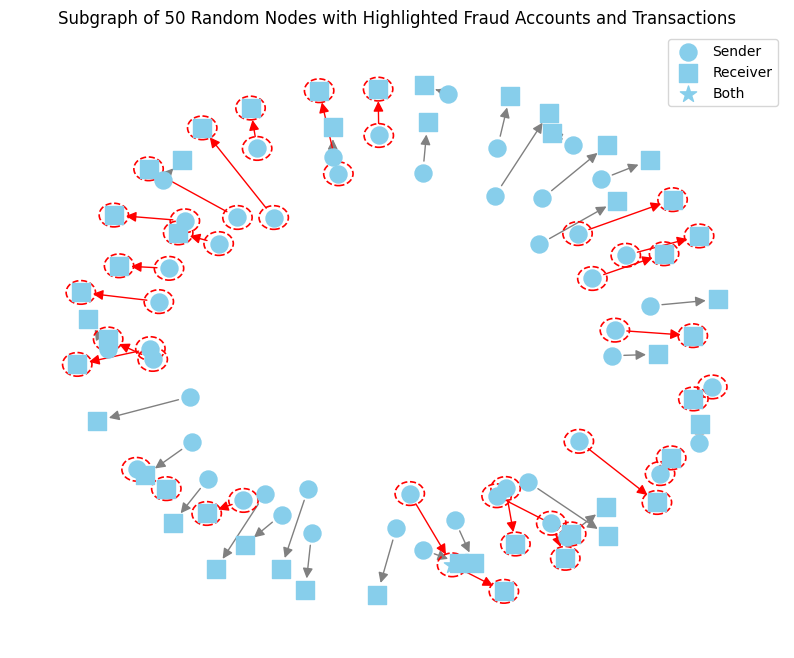

In [ ]:
import matplotlib.patches as mpatches

def visualize_graph(hetero_data, edge_type=('account', 'transacts', 'account'), num_nodes=20):
    import torch
    import matplotlib.pyplot as plt
    import networkx as nx
    from torch_geometric.data import Data
    from torch_geometric.utils import to_networkx

    all_edge_index = hetero_data[edge_type].edge_index
    all_edge_label = hetero_data[edge_type].edge_label.squeeze()

    total_nodes = hetero_data['account'].x.size(0)
    selected_nodes = torch.randperm(total_nodes)[:num_nodes]

    mask = (torch.isin(all_edge_index[0], selected_nodes) | torch.isin(all_edge_index[1], selected_nodes))
    sub_edge_index = all_edge_index[:, mask]
    sub_edge_label = all_edge_label[mask]
    sub_nodes = torch.unique(sub_edge_index.flatten())

    old_to_new = {old.item(): i for i, old in enumerate(sub_nodes)}
    remapped_edge_index = torch.tensor([[old_to_new[src.item()], old_to_new[dst.item()]]
                                        for src, dst in sub_edge_index.t()], dtype=torch.long).t()
    sub_data = Data(edge_index=remapped_edge_index, num_nodes=len(sub_nodes))
    G = to_networkx(sub_data, to_undirected=False)

    original_nodes = list(sub_nodes.numpy())
    original_senders = set(all_edge_index[0][mask].numpy())
    original_receivers = set(all_edge_index[1][mask].numpy())

    only_senders = []
    only_receivers = []
    both = []

    for node in original_nodes:
        is_sender = node in original_senders
        is_receiver = node in original_receivers
        if is_sender and not is_receiver:
            only_senders.append(old_to_new[node])
        elif is_receiver and not is_sender:
            only_receivers.append(old_to_new[node])
        else:
            both.append(old_to_new[node])

    edge_colors = ['red' if is_fraud else 'grey' for is_fraud in sub_edge_label.tolist()]
    pos = nx.spring_layout(G, seed=12, k=0.2)

    plt.figure(figsize=(10, 8))
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=15)

    # Draw base nodes
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=only_senders, node_color='skyblue', node_shape='o', label='Sender')
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=only_receivers, node_color='skyblue', node_shape='s', label='Receiver')
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=both, node_color='skyblue', node_shape='*', label='Both')

    # --- Draw dashed frames for fraud-involved nodes ---
    fraud_edges = sub_edge_label > 0
    fraud_nodes = torch.cat([sub_edge_index[0][fraud_edges], sub_edge_index[1][fraud_edges]]).unique()
    fraud_nodes_remapped = [old_to_new[n.item()] for n in fraud_nodes]

    ax = plt.gca()
    for node in fraud_nodes_remapped:
        x, y = pos[node]
        circle = mpatches.Circle((x, y), radius=0.045, fill=False, edgecolor='red', linestyle='dashed', linewidth=1.2)
        ax.add_patch(circle)

    plt.legend(scatterpoints=1)
    plt.title(f"Subgraph of {num_nodes} Random Nodes with Highlighted Fraud Accounts and Transactions")
    plt.axis('off')
    plt.show()

visualize_graph(hetero_data, edge_type=('account', 'transacts', 'account'), num_nodes=50)

**Context Enhanced**

In [12]:


# ========== Helper Functions ==========

def preprocess_transaction_df(df):
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

    if 'geolocation_(latitude/longitude)' in df.columns:
        df[['latitude', 'longitude']] = df['geolocation_(latitude/longitude)'].str.extract(
            r'([-\d.]+)[^0-9\-]+([-\d.]+)'
        ).astype(float)

    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        df['hour'] = df['timestamp'].dt.hour
        df['minute'] = df['timestamp'].dt.minute
        df['minute_of_day'] = df['hour'] * 60 + df['minute']

    numeric_cols = df.select_dtypes(include=['number']).columns.difference(['fraud_flag']).tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.difference(
        ['timestamp', 'geolocation_(latitude/longitude)', 'sender_account_id', 'receiver_account_id']
    ).tolist()

    for col in categorical_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

    if numeric_cols:
        df[numeric_cols] = StandardScaler().fit_transform(df[numeric_cols])

    return df, numeric_cols, categorical_cols


def build_heterograph(df, numeric_cols, categorical_cols):
    accounts = pd.Index(pd.concat([df['sender_account_id'], df['receiver_account_id']]).unique(), name='account')
    account_id_map = {acc: i for i, acc in enumerate(accounts)}

    data = HeteroData()
    num_nodes = len(accounts)
    data['account'].x = torch.eye(num_nodes)

    senders = df['sender_account_id'].map(account_id_map).values
    receivers = df['receiver_account_id'].map(account_id_map).values
    #edge_index = torch.tensor([senders, receivers], dtype=torch.long)
    edge_index = torch.from_numpy(np.vstack([senders, receivers])).long()

    edge_features = torch.tensor(df[numeric_cols + categorical_cols].values, dtype=torch.float)
    edge_labels = torch.tensor(df['fraud_flag'].astype(int).values, dtype=torch.float).unsqueeze(1)

    data['account', 'transacts', 'account'].edge_index = edge_index
    data['account', 'transacts', 'account'].edge_attr = edge_features
    data['account', 'transacts', 'account'].edge_label = edge_labels
    data['account', 'transacts', 'account'].edge_label_index = edge_index

    return data, account_id_map


def build_behavior_edges(df, threshold=0.95):
    sender_df = df[['pin_code', 'transaction_amount',
                    'transaction_type', 'transaction_status', 'device_used']].copy()
    features = pd.get_dummies(sender_df).fillna(0)
    senders = df['sender_account_id'].values

    sim_matrix = cosine_similarity(features)
    np.fill_diagonal(sim_matrix, 0)

    edge_list, edge_attrs = [], {}
    for i in range(len(senders)):
        for j in range(i + 1, len(senders)):
            if sim_matrix[i, j] >= threshold:
                edge = tuple(sorted((senders[i], senders[j])))
                edge_list.append(edge)
                edge_attrs[edge] = {'behavior_similarity': sim_matrix[i, j]}
    return edge_list, edge_attrs


def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 6371.0 * 2 * atan2(sqrt(a), sqrt(1 - a))


def build_spatial_edges(df, max_distance_km=5):
    df = df.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)
    edge_list, edge_attrs = [], {}

    for i in range(len(df)):
        tx1 = df.iloc[i]
        for j in range(i + 1, len(df)):
            tx2 = df.iloc[j]
            dist = haversine_distance(tx1['latitude'], tx1['longitude'],
                                      tx2['latitude'], tx2['longitude'])
            if dist <= max_distance_km:
                edge = tuple(sorted((tx1['sender_account_id'], tx2['sender_account_id'])))
                edge_list.append(edge)
                edge_attrs[edge] = {'distance_km': dist}
    return edge_list, edge_attrs


def build_temporal_edges(df, time_window='1T', corr_threshold=0.95):
    df['window'] = df['timestamp'].dt.floor(time_window)
    activity_df = df[['sender_account_id', 'window']].rename(columns={'sender_account_id': 'account'})
    activity = pd.crosstab(activity_df['account'], activity_df['window']).clip(upper=1)

    accounts = activity.index.tolist()
    corr_matrix = np.corrcoef(activity.values)

    edge_list, edge_attrs = [], {}
    for i in range(len(accounts)):
        for j in range(i + 1, len(accounts)):
            if corr_matrix[i, j] >= corr_threshold:
                edge = tuple(sorted((accounts[i], accounts[j])))
                edge_list.append(edge)
                edge_attrs[edge] = {'temporal_weight': corr_matrix[i, j]}
    return edge_list, edge_attrs


def build_network_edges(df, threshold=0.85):
    sender_net = df[['sender_account_id', 'network_slice_id', 'latency_(ms)', 'slice_bandwidth_(mbps)']].dropna().drop_duplicates('sender_account_id')
    slice_groups = sender_net.groupby('network_slice_id')
    edge_list, edge_attrs = [], {}

    latency_max = df['latency_(ms)'].max()
    bandwidth_max = df['slice_bandwidth_(mbps)'].max()

    for _, group in slice_groups:
        group = group.set_index('sender_account_id')
        accounts = group.index.tolist()
        for i in range(len(accounts)):
            for j in range(i + 1, len(accounts)):
                a1, a2 = accounts[i], accounts[j]
                lat_sim = 1 - abs(group.loc[a1, 'latency_(ms)'] - group.loc[a2, 'latency_(ms)']) / latency_max
                bw_sim = 1 - abs(group.loc[a1, 'slice_bandwidth_(mbps)'] - group.loc[a2, 'slice_bandwidth_(mbps)']) / bandwidth_max
                score = (lat_sim + bw_sim) / 2
                if score >= threshold:
                    edge = tuple(sorted((a1, a2)))
                    edge_list.append(edge)
                    edge_attrs[edge] = {'network_similarity': score}
    return edge_list, edge_attrs


def add_similarity_edges(data, edge_list, edge_attrs, edge_type_name, attr_key, account_id_map):
    edge_index, edge_attr = [], []
    for (a1, a2), attr in edge_attrs.items():
        if a1 in account_id_map and a2 in account_id_map:
            i, j = account_id_map[a1], account_id_map[a2]
            edge_index.extend([[i, j], [j, i]])  # undirected
            edge_attr.extend([attr[attr_key]] * 2)

    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).T
        edge_attr = torch.tensor(edge_attr, dtype=torch.float).unsqueeze(1)
        data['account', edge_type_name, 'account'].edge_index = edge_index
        data['account', edge_type_name, 'account'].edge_attr = edge_attr


# ========== Main Execution ==========

if __name__ == '__main__':
    df = df_raw.copy()
    df, numeric_cols, categorical_cols = preprocess_transaction_df(df)

    hetero_data_v2, account_id_map = build_heterograph(df, numeric_cols, categorical_cols)

    # Build and add similarity edges
    be_edges, be_attrs = build_behavior_edges(df)
    add_similarity_edges(hetero_data_v2, be_edges, be_attrs, 'behavior_similar', 'behavior_similarity', account_id_map)

    sp_edges, sp_attrs = build_spatial_edges(df)
    add_similarity_edges(hetero_data_v2, sp_edges, sp_attrs, 'spatial_close', 'distance_km', account_id_map)

    tp_edges, tp_attrs = build_temporal_edges(df)
    add_similarity_edges(hetero_data_v2, tp_edges, tp_attrs, 'temporally_active', 'temporal_weight', account_id_map)

    nw_edges, nw_attrs = build_network_edges(df)
    add_similarity_edges(hetero_data_v2, nw_edges, nw_attrs, 'network_similar', 'network_similarity', account_id_map)

    print(hetero_data_v2)


<ipython-input-12-4455c462527b>:99: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['window'] = df['timestamp'].dt.floor(time_window)


HeteroData(
  account={ x=[1971, 1971] },
  (account, transacts, account)={
    edge_index=[2, 1000],
    edge_attr=[1000, 14],
    edge_label=[1000, 1],
    edge_label_index=[2, 1000],
  },
  (account, behavior_similar, account)={
    edge_index=[2, 11480],
    edge_attr=[11480, 1],
  },
  (account, spatial_close, account)={
    edge_index=[2, 38394],
    edge_attr=[38394, 1],
  },
  (account, temporally_active, account)={
    edge_index=[2, 16204],
    edge_attr=[16204, 1],
  },
  (account, network_similar, account)={
    edge_index=[2, 6702],
    edge_attr=[6702, 1],
  }
)


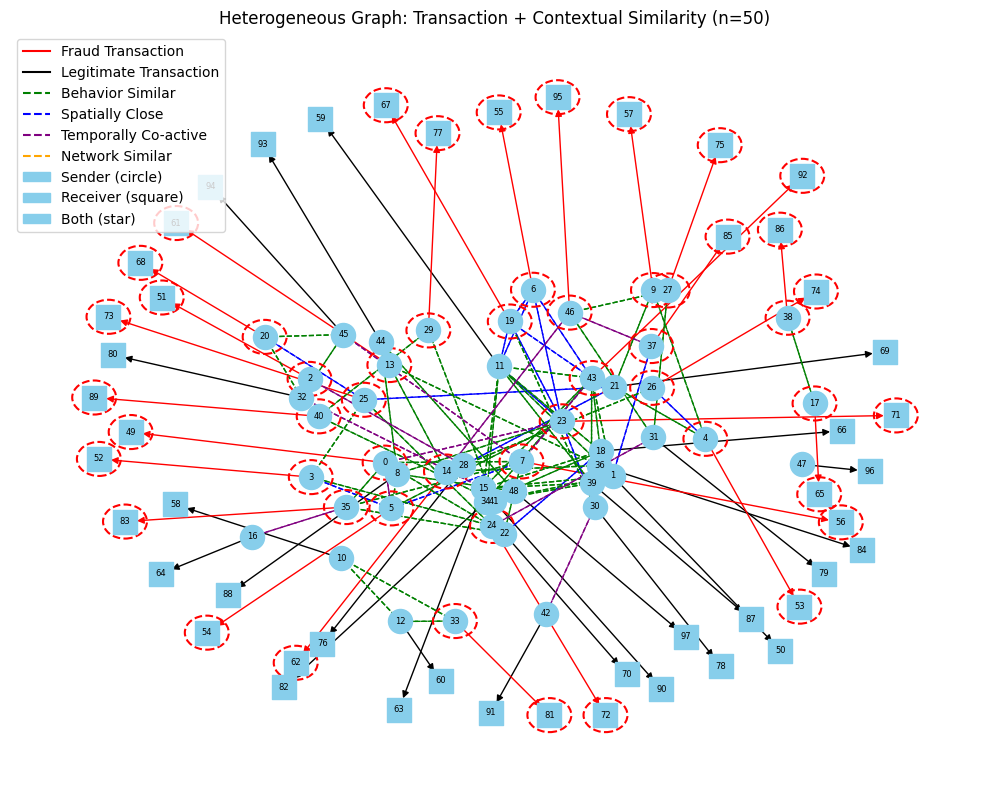

In [33]:


def visualize_hetero_transaction_graph_with_context(hetero_data,
                                                    base_edge_type=('account', 'transacts', 'account'),
                                                    num_nodes=30,
                                                    extra_edge_types=None):
    # Step 1: Sample random nodes
    total_nodes = hetero_data['account'].x.size(0)
    selected_nodes = torch.randperm(total_nodes)[:num_nodes]

    # Step 2: Get base transaction edges (fraud-labeled)
    base_edge_index = hetero_data[base_edge_type].edge_index
    base_edge_label = hetero_data[base_edge_type].edge_label.squeeze()

    # Filter base transaction edges where either node is in selected set
    mask = (torch.isin(base_edge_index[0], selected_nodes) | torch.isin(base_edge_index[1], selected_nodes))
    sub_base_edge_index = base_edge_index[:, mask]
    sub_base_edge_label = base_edge_label[mask]

    # Collect nodes from those filtered edges
    sub_nodes = torch.unique(sub_base_edge_index.flatten())
    old_to_new = {old.item(): i for i, old in enumerate(sub_nodes)}

    # Remap edge indices
    remapped_base_edge_index = torch.tensor([[old_to_new[src.item()], old_to_new[dst.item()]]
                                             for src, dst in sub_base_edge_index.t()], dtype=torch.long).t()
    remapped_base_edge_label = sub_base_edge_label

    # Step 3: Start building networkx graph with base transaction edges
    G = nx.DiGraph()
    for i in range(remapped_base_edge_index.size(1)):
        src, dst = remapped_base_edge_index[:, i].tolist()
        G.add_edge(src, dst, label='transacts', fraud=remapped_base_edge_label[i].item())

    # Step 4: Add extra edge types (undirected similarity edges)
    extra_edge_types = extra_edge_types or [
        ('account', 'behavior_similar', 'account'),
        ('account', 'spatial_close', 'account'),
        ('account', 'temporally_coactive', 'account'),
        ('account', 'network_similar', 'account')
    ]
    color_map = {
        'transacts': 'red',
        'behavior_similar': 'blue',
        'spatial_close': 'green',
        'temporally_active': 'orange',
        'network_similar': 'purple'
    }

    for edge_type in extra_edge_types:
        if edge_type not in hetero_data.edge_types:
            continue
        edge_index = hetero_data[edge_type].edge_index
        mask = (torch.isin(edge_index[0], sub_nodes) & torch.isin(edge_index[1], sub_nodes))
        sub_edge_index = edge_index[:, mask]

        for i in range(sub_edge_index.size(1)):
            src = sub_edge_index[0, i].item()
            dst = sub_edge_index[1, i].item()
            if src in old_to_new and dst in old_to_new:
                src_new, dst_new = old_to_new[src], old_to_new[dst]
                G.add_edge(src_new, dst_new, label=edge_type[1], fraud=0)
                G.add_edge(dst_new, src_new, label=edge_type[1], fraud=0)  # Undirected

    # Step 5: Draw the graph
    pos = nx.spring_layout(G, seed=12, k=0.2)
    plt.figure(figsize=(10, 8))

    # Draw nodes by role
    original_senders = set(sub_base_edge_index[0].numpy())
    original_receivers = set(sub_base_edge_index[1].numpy())
    only_senders, only_receivers, both = [], [], []

    for node in sub_nodes.numpy():
        remapped = old_to_new[node]
        is_sender = node in original_senders
        is_receiver = node in original_receivers
        if is_sender and not is_receiver:
            only_senders.append(remapped)
        elif is_receiver and not is_sender:
            only_receivers.append(remapped)
        else:
            both.append(remapped)

    nx.draw_networkx_nodes(G, pos, nodelist=only_senders, node_shape='o', node_color='skyblue', label='Sender', node_size=300)
    nx.draw_networkx_nodes(G, pos, nodelist=only_receivers, node_shape='s', node_color='skyblue', label='Receiver', node_size=300)
    nx.draw_networkx_nodes(G, pos, nodelist=both, node_shape='*', node_color='skyblue', label='Both', node_size=300)

    # Draw edges by type
    for edge_type in color_map:
        if edge_type == 'transacts':
            # Separate fraud and non-fraud edges
            fraud_edges = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == 'transacts' and d['fraud'] == 1]
            normal_edges = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == 'transacts' and d['fraud'] == 0]
            # Draw normal (non-fraud) transaction edges in black
            nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='black', style='solid', arrows=True)
            # Draw fraud transaction edges in red
            nx.draw_networkx_edges(G, pos, edgelist=fraud_edges, edge_color='red', style='solid', arrows=True)
        else:
            # For other (undirected) similarity edge types
            edges = [(u, v) for u, v, d in G.edges(data=True) if d['label'] == edge_type]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color_map[edge_type], style='dashed', arrows=False)


    # Highlight fraud nodes
    fraud_nodes = [u for u, v, d in G.edges(data=True) if d['label'] == 'transacts' and d['fraud'] == 1]
    fraud_nodes += [v for u, v, d in G.edges(data=True) if d['label'] == 'transacts' and d['fraud'] == 1]
    fraud_nodes = list(set(fraud_nodes))
    ax = plt.gca()
    for node in fraud_nodes:
        x, y = pos[node]
        circ = mpatches.Circle((x, y), radius=0.05, edgecolor='red', linestyle='dashed', linewidth=1.5, fill=False)
        ax.add_patch(circ)

    # Label nodes
    nx.draw_networkx_labels(G, pos, font_size=6)

    # Legend

    edge_legend = [
    mlines.Line2D([], [], color='red', linestyle='-', label='Fraud Transaction'),
    mlines.Line2D([], [], color='black', linestyle='-', label='Legitimate Transaction'),
    mlines.Line2D([], [], color='green', linestyle='--', label='Behavior Similar'),
    mlines.Line2D([], [], color='blue', linestyle='--', label='Spatially Close'),
    mlines.Line2D([], [], color='purple', linestyle='--', label='Temporally Co-active'),
    mlines.Line2D([], [], color='orange', linestyle='--', label='Network Similar')
]
    node_legend = [
        mpatches.Patch(color='skyblue', label='Sender (circle)'),
        mpatches.Patch(color='skyblue', label='Receiver (square)'),
        mpatches.Patch(color='skyblue', label='Both (star)')
    ]
    plt.legend(handles=edge_legend + node_legend, loc='best')
    plt.title(f"Heterogeneous Graph: Transaction + Contextual Similarity (n={num_nodes})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_hetero_transaction_graph_with_context(hetero_data_v2,
                                                    base_edge_type=('account', 'transacts', 'account'),
                                                    num_nodes=50)

## 4. Dataset Preparation

In [ ]:
def Stratified_split_dataset(data, edge_type, test_ratio=0.2, seed=12):
    """Initial split into train_val (80%) and test (20%)"""
    edge_label_index = data[edge_type].edge_label_index.cpu().numpy().T
    edge_label = data[edge_type].edge_label.cpu().numpy()

    # Stratified split
    train_val_idx, test_idx = train_test_split(
        np.arange(len(edge_label)),
        test_size=test_ratio,
        stratify=edge_label,
        random_state=seed
    )

    return {
        'train_val': {
            'edge_index': edge_label_index[train_val_idx].T,
            'edge_label': edge_label[train_val_idx]
        },
        'test': {
            'edge_index': edge_label_index[test_idx].T,
            'edge_label': edge_label[test_idx]
        }
    }

splits = Stratified_split_dataset(hetero_data, edge_type=('account', 'transacts', 'account'), seed=12)

## 5. Define GNN Models

In [ ]:
# === Baseline 1: GCN ===

class FraudHeteroGCN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels=64, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.edge_type = ('account', 'transacts', 'account')  # Target edge type

        # First GCN layer
        self.conv1 = HeteroConv({
            self.edge_type: GCNConv(-1, hidden_channels)
        }, aggr='mean')

        # Second GCN layer
        self.conv2 = HeteroConv({
            self.edge_type: GCNConv(hidden_channels, hidden_channels)
        }, aggr='mean')

        # Normalization layers
        self.norm1 = LayerNorm(hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)

        # Enhanced edge predictor
        self.edge_predictor = nn.Sequential(
            Linear(4 * hidden_channels, hidden_channels),  # 4x from feature interactions
            nn.ELU(),
            Dropout(p=dropout),
            Linear(hidden_channels, hidden_channels),
            nn.ELU(),
            Linear(hidden_channels, 1)
        )

    def forward(self, x_dict, edge_index_dict):
        # First GCN layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: self.norm1(F.elu(x)) for k, x in x_dict.items()}
        x_dict = {k: F.dropout(x, p=self.dropout, training=self.training)
                 for k, x in x_dict.items()}

        # Second GCN layer with residual connection
        x_dict_conv = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: self.norm2(F.elu(x_dict_conv[k] + x_dict[k]))  # Skip connection
                 for k in x_dict}
        x_dict = {k: F.dropout(x, p=self.dropout, training=self.training)
                 for k, x in x_dict.items()}

        return x_dict

    def decode(self, z_dict, edge_index):
        src, dst = edge_index
        z_src = z_dict['account'][src]
        z_dst = z_dict['account'][dst]

        # Enhanced feature interactions
        z_edge = torch.cat([
            z_src,
            z_dst,
            z_src * z_dst,                # Element-wise product
            torch.abs(z_src - z_dst)       # Absolute difference
        ], dim=1)

        return self.edge_predictor(z_edge)


In [ ]:
# === Baseline 2: SAGE ===

class FraudHeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        self.hidden_channels = hidden_channels
        self.edge_type = ('account', 'transacts', 'account')

        # === GNN Layers ===
        self.conv1 = HeteroConv({
            self.edge_type: SAGEConv((-1, -1), hidden_channels)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            self.edge_type: SAGEConv((hidden_channels, hidden_channels), hidden_channels)
        }, aggr='mean')

        # === Normalization Layers ===
        self.norm1 = torch.nn.LayerNorm(hidden_channels)
        self.norm2 = torch.nn.LayerNorm(hidden_channels)

        # === Edge Prediction Decoder ===
        self.edge_predictor = Sequential(
            Linear(4 * hidden_channels, hidden_channels),
            ReLU(),
            Dropout(p=dropout),
            Linear(hidden_channels, 1)
        )

    def forward(self, x_dict, edge_index_dict):
        # First GNN layer + norm + relu + dropout
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: self.norm1(x) for k, x in x_dict.items()}
        x_dict = {k: F.relu(x) for k, x in x_dict.items()}
        x_dict = {k: F.dropout(x, p=self.dropout, training=self.training) for k, x in x_dict.items()}

        # Second GNN layer + norm + dropout
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: self.norm2(x) for k, x in x_dict.items()}
        x_dict = {k: F.dropout(x, p=self.dropout, training=self.training) for k, x in x_dict.items()}

        return x_dict

    def decode(self, z_dict, edge_index):
        src, dst = edge_index
        z_src = z_dict['account'][src]
        z_dst = z_dict['account'][dst]

        # Enhanced edge features: concat + product + difference
        z_edge = torch.cat([
            z_src,
            z_dst,
            z_src * z_dst,
            torch.abs(z_src - z_dst)
        ], dim=1)

        return self.edge_predictor(z_edge)


In [ ]:
# === Enhanced: GAT (Attention & Respect Edge Direction) ===

class FraudHeteroGAT(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, dropout=0.3, heads=2):
        super().__init__()
        self.dropout = dropout
        self.hidden_channels = hidden_channels
        self.edge_type = ('account', 'transacts', 'account')

        # === GATConv Layers ===
        self.conv1 = HeteroConv({
            self.edge_type: GATConv((-1, -1), hidden_channels, heads=heads, concat=True)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            self.edge_type: GATConv(
                (hidden_channels * heads, hidden_channels * heads),
                hidden_channels,
                heads=1,
                concat=False
            )
        }, aggr='mean')

        # === Normalization ===
        self.norm1 = LayerNorm(hidden_channels * heads)
        self.norm2 = LayerNorm(hidden_channels)

        # === Edge Predictor ===
        self.edge_dim = 4 * hidden_channels
        self.edge_predictor = Sequential(
            nn.Linear(self.edge_dim, hidden_channels),
            ReLU(),
            Dropout(p=dropout),
            Linear(hidden_channels, 1)
        )

    def forward(self, x_dict, edge_index_dict):
        # First GAT layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: self.norm1(x) for k, x in x_dict.items()}
        x_dict = {k: F.elu(x) for k, x in x_dict.items()}
        x_dict = {k: F.dropout(x, p=self.dropout, training=self.training) for k, x in x_dict.items()}

        # Second GAT layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict = {k: self.norm2(x) for k, x in x_dict.items()}
        x_dict = {k: F.dropout(x, p=self.dropout, training=self.training) for k, x in x_dict.items()}

        return x_dict

    def decode(self, z_dict, edge_index):
        src, dst = edge_index
        z_src = z_dict['account'][src]
        z_dst = z_dict['account'][dst]

        z_edge = torch.cat([
            z_src,
            z_dst,
            z_src * z_dst,
            torch.abs(z_src - z_dst)
        ], dim=1)

        return self.edge_predictor(z_edge)


## 6. Model Training

In [ ]:
# === Early Stopping ===
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.verbose = verbose

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered. Best val loss: {self.best_loss:.4f}")

# === K-fold data preparation ===
def prepare_kfold_edges(train_val_data, n_splits=5, seed=12):
    """
    Prepare k-fold splits from train_val data only.
    """
    edge_index = train_val_data['edge_index']
    edge_label = train_val_data['edge_label']

    # Convert to numpy for StratifiedKFold
    edge_index_np = edge_index.cpu().numpy().T if isinstance(edge_index, torch.Tensor) else edge_index.T
    edge_label_np = edge_label.cpu().numpy() if isinstance(edge_label, torch.Tensor) else edge_label

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    edge_folds = []

    for train_idx, val_idx in skf.split(edge_index_np, edge_label_np):
        fold_dict = {
            'train_edge_index': torch.tensor(edge_index_np[train_idx].T, dtype=torch.long),
            'train_edge_label': torch.tensor(edge_label_np[train_idx], dtype=torch.long),
            'val_edge_index': torch.tensor(edge_index_np[val_idx].T, dtype=torch.long),
            'val_edge_label': torch.tensor(edge_label_np[val_idx], dtype=torch.long)
        }
        edge_folds.append(fold_dict)

    return edge_folds


# === Training function ===
def train(model, data, optimizer, fold_data, device):
    model.train()
    optimizer.zero_grad()

    edge_type = ('account', 'transacts', 'account')
    z_dict = model(data.x_dict, data.edge_index_dict)

    edge_index = fold_data['train_edge_index'].to(device)
    edge_label = fold_data['train_edge_label'].to(device).squeeze()

    logits = model.decode(z_dict, edge_index).squeeze()
    loss = F.binary_cross_entropy_with_logits(logits, edge_label.float())
    loss.backward()
    optimizer.step()
    return loss.item()

# === Evaluation function ===
@torch.no_grad()
def evaluate(model, data, fold_data, split='val', device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    edge_index = fold_data[f'{split}_edge_index'].to(device)
    edge_label = fold_data[f'{split}_edge_label'].to(device).squeeze()

    z_dict = model(data.x_dict, data.edge_index_dict)
    logits = model.decode(z_dict, edge_index).squeeze()

    loss = F.binary_cross_entropy_with_logits(logits, edge_label.float())

    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs > 0.5).astype(float)
    y_true = edge_label.cpu().numpy()

    metrics = {
        'loss': loss.item(),
        'accuracy': accuracy_score(y_true, preds),
        'precision': precision_score(y_true, preds, zero_division=0),
        'recall': recall_score(y_true, preds, zero_division=0),
        'f1': f1_score(y_true, preds, zero_division=0),
        'auc': roc_auc_score(y_true, probs) if len(np.unique(y_true)) > 1 else 0.5
    }

    return metrics, probs, logits

# === Plot learning curves ===
def plot_learning_curves(history, model_name, fold_idx, save_path=None):
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', color='blue')
    plt.plot(history['val_loss'], label='Val Loss',  color='orange')
    plt.title(f'{model_name} - Fold {fold_idx+1}: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', color='green')
    plt.plot(history['val_acc'], label='Val Accuracy',  color='red')
    plt.title(f'{model_name} - Fold {fold_idx+1}: Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# === Main training function ===
def train_model(model_class, data, fold_data, fold_idx, config, device, output_dir=None):
    model = model_class(data.metadata(), **config['model_params']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'],  weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=config['factor'], patience=5, verbose=config['verbose'])
    early_stopping = EarlyStopping(patience=5, verbose=config['verbose'])

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_auc': [], 'val_auc': []
    }

    for epoch in range(1, config['epochs'] + 1):
        train_loss = train(model, data, optimizer, fold_data, device)
        train_metrics, _, _ = evaluate(model, data, fold_data, 'train', device)
        val_metrics, _, _ = evaluate(model, data, fold_data, 'val', device)

        # Record history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_metrics['loss'])
        history['train_acc'].append(train_metrics['accuracy'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['train_auc'].append(train_metrics['auc'])
        history['val_auc'].append(val_metrics['auc'])

        # Print progress
        if config['verbose']:
            print(f"Fold {fold_idx+1}, Epoch {epoch:03d}: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_metrics['accuracy']:.4f}, "
                  f"Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

        # Update scheduler and check early stopping
        scheduler.step(val_metrics['loss'])
        early_stopping(val_metrics['loss'])
        if early_stopping.early_stop:
            if config['verbose']:
                print(f"Early stopping at epoch {epoch}")
            break
      # Plot learning curves
    if config['plot_curves']:
      plot_learning_curves(history, config['model_name'], fold_idx, output_dir)

    return model, history

# === Main experiment function ===
def run_experiment(model_class, config, data, device, output_dir=None):
    print(f"\n{'='*50}")
    print(f" Running {config['model_name']} Experiment")
    print(f"{'='*50}")

    set_seed(config['seed'])
    edge_type = ('account', 'transacts', 'account')
    edge_folds = prepare_kfold_edges(splits['train_val'], n_splits=config['n_folds'], seed=config['seed'])

    # Create output directory if it doesn't exist
    model_dir = os.path.join(output_dir, config['model_name'])
    os.makedirs(model_dir, exist_ok=True)  #

    all_metrics = []
    all_histories = []

    for fold_idx in range(config['n_folds']):
        print(f"\nFold {fold_idx+1}/{config['n_folds']}")

        model, history = train_model(
            model_class, data, edge_folds[fold_idx], fold_idx, config, device, output_dir)

        # Evaluate on validation set
        val_metrics, _, _ = evaluate(model, data, edge_folds[fold_idx], 'val', device)
        all_metrics.append(val_metrics)
        all_histories.append(history)

        # Save fold-wise model
        torch.save(model.state_dict(),
                  os.path.join(output_dir, f'best_fold{fold_idx}.pt'))

        print(f"\nFold {fold_idx+1} Validation Results:")
        print(f"  Accuracy:  {val_metrics['accuracy']:.4f}")
        print(f"  AUC-ROC:   {val_metrics['auc']:.4f}")
        print(f"  Precision: {val_metrics['precision']:.4f}")
        print(f"  Recall:    {val_metrics['recall']:.4f}")
        print(f"  F1 Score:  {val_metrics['f1']:.4f}")

    # Calculate average metrics
    avg_metrics = {
        'accuracy': np.mean([m['accuracy'] for m in all_metrics]),
        'auc': np.mean([m['auc'] for m in all_metrics]),
        'precision': np.mean([m['precision'] for m in all_metrics]),
        'recall': np.mean([m['recall'] for m in all_metrics]),
        'f1': np.mean([m['f1'] for m in all_metrics])
    }

    std_metrics = {
        'accuracy': np.std([m['accuracy'] for m in all_metrics]),
        'auc': np.std([m['auc'] for m in all_metrics]),
        'precision': np.std([m['precision'] for m in all_metrics]),
        'recall': np.std([m['recall'] for m in all_metrics]),
        'f1': np.std([m['f1'] for m in all_metrics])
    }

    print(f"\n{'-'*50}")
    print(f"Average Validation Metrics over {config['n_folds']} folds:")
    print(f"Avg Accuracy    : {avg_metrics['accuracy']:.4f} ± {std_metrics['accuracy']:.4f}")
    print(f"Avg AUC         : {avg_metrics['auc']:.4f} ± {std_metrics['auc']:.4f}")
    print(f"Avg Precision   : {avg_metrics['precision']:.4f} ± {std_metrics['precision']:.4f}")
    print(f"Avg Recall      : {avg_metrics['recall']:.4f} ± {std_metrics['recall']:.4f}")
    print(f"Avg F1-score    : {avg_metrics['f1']:.4f} ± {std_metrics['f1']:.4f}")

    return avg_metrics, std_metrics, all_histories

In [ ]:
# Create a variable to save model results
all_results = {}

**== GCN ==**

Using device: cpu

 Running GCN Experiment

Fold 1/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1, Epoch 001: Train Loss: 0.6989, Train Acc: 0.4922, Val Loss: 0.6971, Val Acc: 0.4906
Fold 1, Epoch 002: Train Loss: 0.6989, Train Acc: 0.4961, Val Loss: 0.6956, Val Acc: 0.4906
Fold 1, Epoch 003: Train Loss: 0.6938, Train Acc: 0.4984, Val Loss: 0.6942, Val Acc: 0.4906
Fold 1, Epoch 004: Train Loss: 0.6933, Train Acc: 0.5008, Val Loss: 0.6927, Val Acc: 0.4906
Fold 1, Epoch 005: Train Loss: 0.6915, Train Acc: 0.5023, Val Loss: 0.6914, Val Acc: 0.4938
Fold 1, Epoch 006: Train Loss: 0.6887, Train Acc: 0.5039, Val Loss: 0.6900, Val Acc: 0.4938
Fold 1, Epoch 007: Train Loss: 0.6868, Train Acc: 0.5078, Val Loss: 0.6886, Val Acc: 0.4969
Fold 1, Epoch 008: Train Loss: 0.6872, Train Acc: 0.5094, Val Loss: 0.6873, Val Acc: 0.5000
Fold 1, Epoch 009: Train Loss: 0.6840, Train Acc: 0.5133, Val Loss: 0.6859, Val Acc: 0.5000
Fold 1, Epoch 010: Train Loss: 0.6797, Train Acc: 0.5188, Val Loss: 0.6845, Val Acc: 0.5031
Fold 1, Epoch 011: Train Loss: 0.6773, Train Acc: 0.5273, Val Loss: 0.6832, Val 

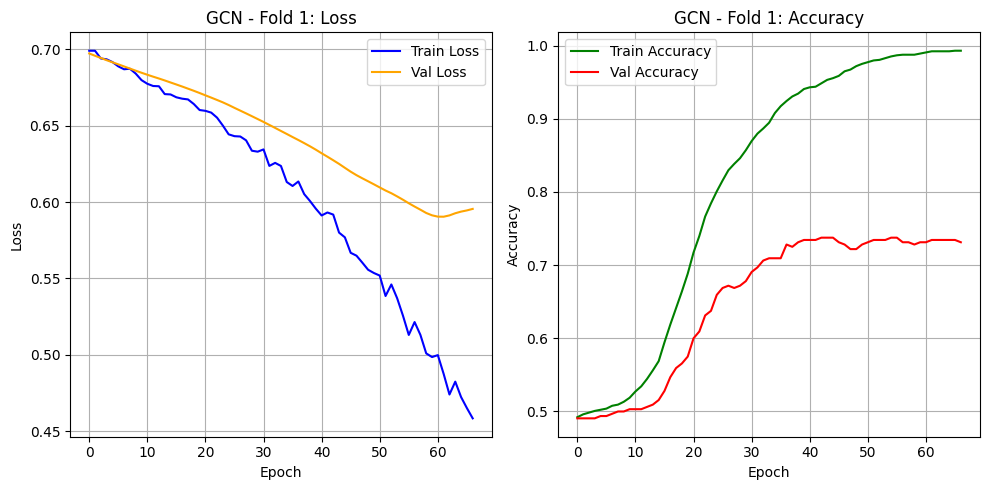


Fold 1 Validation Results:
  Accuracy:  0.7312
  AUC-ROC:   0.7950
  Precision: 0.6568
  Recall:    0.9688
  F1 Score:  0.7828

Fold 2/5
Fold 2, Epoch 001: Train Loss: 0.7077, Train Acc: 0.3672, Val Loss: 0.7127, Val Acc: 0.3156
Fold 2, Epoch 002: Train Loss: 0.7090, Train Acc: 0.4023, Val Loss: 0.7101, Val Acc: 0.3187
Fold 2, Epoch 003: Train Loss: 0.7034, Train Acc: 0.4250, Val Loss: 0.7077, Val Acc: 0.3406
Fold 2, Epoch 004: Train Loss: 0.7024, Train Acc: 0.4648, Val Loss: 0.7054, Val Acc: 0.3656


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 2, Epoch 005: Train Loss: 0.6972, Train Acc: 0.4914, Val Loss: 0.7033, Val Acc: 0.3844
Fold 2, Epoch 006: Train Loss: 0.6978, Train Acc: 0.5320, Val Loss: 0.7014, Val Acc: 0.4031
Fold 2, Epoch 007: Train Loss: 0.6957, Train Acc: 0.5789, Val Loss: 0.6996, Val Acc: 0.4281
Fold 2, Epoch 008: Train Loss: 0.6936, Train Acc: 0.6117, Val Loss: 0.6979, Val Acc: 0.4625
Fold 2, Epoch 009: Train Loss: 0.6896, Train Acc: 0.6344, Val Loss: 0.6963, Val Acc: 0.4906
Fold 2, Epoch 010: Train Loss: 0.6890, Train Acc: 0.6578, Val Loss: 0.6949, Val Acc: 0.5062
Fold 2, Epoch 011: Train Loss: 0.6877, Train Acc: 0.6766, Val Loss: 0.6936, Val Acc: 0.5344
Fold 2, Epoch 012: Train Loss: 0.6856, Train Acc: 0.7047, Val Loss: 0.6923, Val Acc: 0.5375
Fold 2, Epoch 013: Train Loss: 0.6816, Train Acc: 0.7289, Val Loss: 0.6912, Val Acc: 0.5500
Fold 2, Epoch 014: Train Loss: 0.6811, Train Acc: 0.7469, Val Loss: 0.6901, Val Acc: 0.5656
Fold 2, Epoch 015: Train Loss: 0.6804, Train Acc: 0.7641, Val Loss: 0.6890, Val 

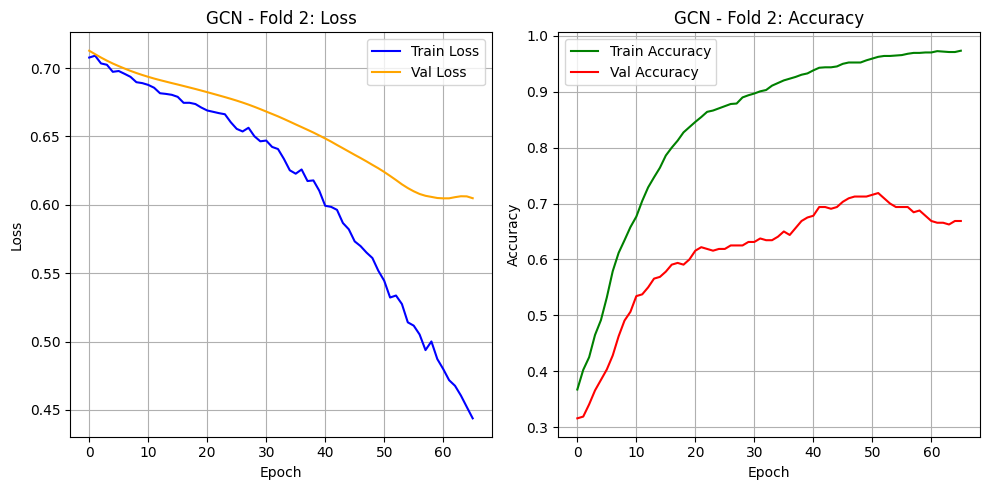


Fold 2 Validation Results:
  Accuracy:  0.6687
  AUC-ROC:   0.7412
  Precision: 0.6421
  Recall:    0.7625
  F1 Score:  0.6971

Fold 3/5
Fold 3, Epoch 001: Train Loss: 0.7099, Train Acc: 0.3445, Val Loss: 0.7086, Val Acc: 0.3656
Fold 3, Epoch 002: Train Loss: 0.7083, Train Acc: 0.3594, Val Loss: 0.7064, Val Acc: 0.3719
Fold 3, Epoch 003: Train Loss: 0.7076, Train Acc: 0.3742, Val Loss: 0.7042, Val Acc: 0.3969
Fold 3, Epoch 004: Train Loss: 0.7058, Train Acc: 0.3961, Val Loss: 0.7022, Val Acc: 0.4094


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 3, Epoch 005: Train Loss: 0.6998, Train Acc: 0.4148, Val Loss: 0.7003, Val Acc: 0.4094
Fold 3, Epoch 006: Train Loss: 0.6971, Train Acc: 0.4453, Val Loss: 0.6984, Val Acc: 0.4125
Fold 3, Epoch 007: Train Loss: 0.6989, Train Acc: 0.4758, Val Loss: 0.6966, Val Acc: 0.4188
Fold 3, Epoch 008: Train Loss: 0.6951, Train Acc: 0.5039, Val Loss: 0.6948, Val Acc: 0.4437
Fold 3, Epoch 009: Train Loss: 0.6949, Train Acc: 0.5352, Val Loss: 0.6930, Val Acc: 0.4781
Fold 3, Epoch 010: Train Loss: 0.6926, Train Acc: 0.5664, Val Loss: 0.6912, Val Acc: 0.5219
Fold 3, Epoch 011: Train Loss: 0.6901, Train Acc: 0.6008, Val Loss: 0.6894, Val Acc: 0.5500
Fold 3, Epoch 012: Train Loss: 0.6868, Train Acc: 0.6320, Val Loss: 0.6876, Val Acc: 0.5719
Fold 3, Epoch 013: Train Loss: 0.6868, Train Acc: 0.6609, Val Loss: 0.6858, Val Acc: 0.5813
Fold 3, Epoch 014: Train Loss: 0.6805, Train Acc: 0.6914, Val Loss: 0.6839, Val Acc: 0.5938
Fold 3, Epoch 015: Train Loss: 0.6841, Train Acc: 0.7109, Val Loss: 0.6820, Val 

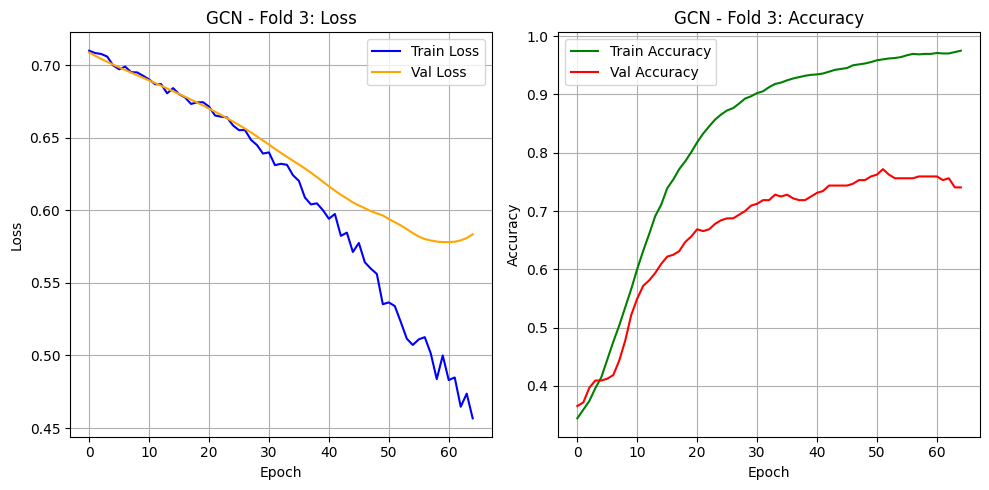


Fold 3 Validation Results:
  Accuracy:  0.7406
  AUC-ROC:   0.7232
  Precision: 0.6696
  Recall:    0.9500
  F1 Score:  0.7855

Fold 4/5
Fold 4, Epoch 001: Train Loss: 0.7395, Train Acc: 0.4961, Val Loss: 0.7327, Val Acc: 0.4938
Fold 4, Epoch 002: Train Loss: 0.7366, Train Acc: 0.5078, Val Loss: 0.7275, Val Acc: 0.4938


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 4, Epoch 003: Train Loss: 0.7227, Train Acc: 0.5164, Val Loss: 0.7224, Val Acc: 0.4875
Fold 4, Epoch 004: Train Loss: 0.7178, Train Acc: 0.5227, Val Loss: 0.7175, Val Acc: 0.5031
Fold 4, Epoch 005: Train Loss: 0.7159, Train Acc: 0.5328, Val Loss: 0.7129, Val Acc: 0.5188
Fold 4, Epoch 006: Train Loss: 0.7028, Train Acc: 0.5469, Val Loss: 0.7085, Val Acc: 0.5281
Fold 4, Epoch 007: Train Loss: 0.7027, Train Acc: 0.5570, Val Loss: 0.7042, Val Acc: 0.5312
Fold 4, Epoch 008: Train Loss: 0.6978, Train Acc: 0.5711, Val Loss: 0.6999, Val Acc: 0.5281
Fold 4, Epoch 009: Train Loss: 0.6913, Train Acc: 0.5844, Val Loss: 0.6956, Val Acc: 0.5375
Fold 4, Epoch 010: Train Loss: 0.6829, Train Acc: 0.6055, Val Loss: 0.6914, Val Acc: 0.5437
Fold 4, Epoch 011: Train Loss: 0.6801, Train Acc: 0.6219, Val Loss: 0.6873, Val Acc: 0.5500
Fold 4, Epoch 012: Train Loss: 0.6813, Train Acc: 0.6445, Val Loss: 0.6833, Val Acc: 0.5687
Fold 4, Epoch 013: Train Loss: 0.6689, Train Acc: 0.6594, Val Loss: 0.6794, Val 

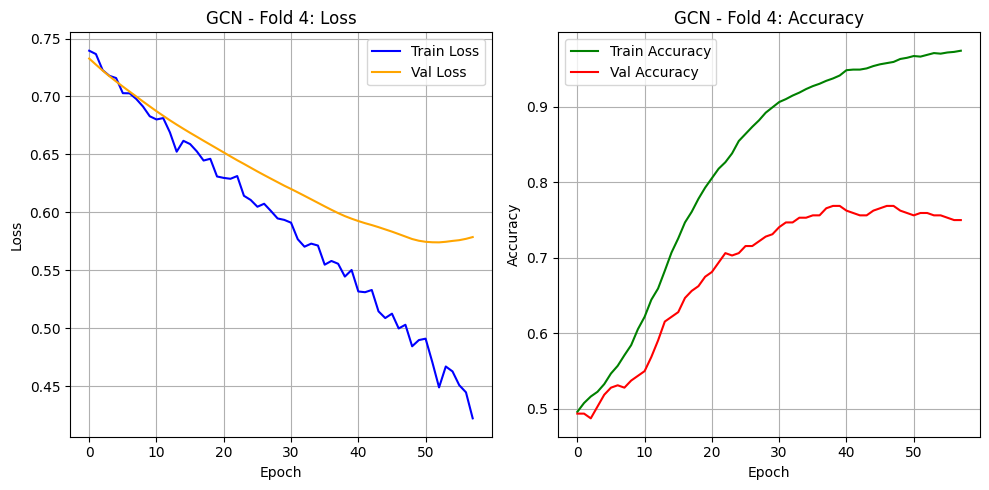


Fold 4 Validation Results:
  Accuracy:  0.7500
  AUC-ROC:   0.7637
  Precision: 0.6739
  Recall:    0.9688
  F1 Score:  0.7949

Fold 5/5
Fold 5, Epoch 001: Train Loss: 0.7079, Train Acc: 0.5086, Val Loss: 0.7027, Val Acc: 0.5094
Fold 5, Epoch 002: Train Loss: 0.7051, Train Acc: 0.5133, Val Loss: 0.7005, Val Acc: 0.5094
Fold 5, Epoch 003: Train Loss: 0.7013, Train Acc: 0.5203, Val Loss: 0.6982, Val Acc: 0.5094
Fold 5, Epoch 004: Train Loss: 0.6955, Train Acc: 0.5273, Val Loss: 0.6960, Val Acc: 0.5156


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 5, Epoch 005: Train Loss: 0.6948, Train Acc: 0.5328, Val Loss: 0.6938, Val Acc: 0.5250
Fold 5, Epoch 006: Train Loss: 0.6903, Train Acc: 0.5422, Val Loss: 0.6917, Val Acc: 0.5312
Fold 5, Epoch 007: Train Loss: 0.6885, Train Acc: 0.5563, Val Loss: 0.6896, Val Acc: 0.5312
Fold 5, Epoch 008: Train Loss: 0.6855, Train Acc: 0.5742, Val Loss: 0.6875, Val Acc: 0.5312
Fold 5, Epoch 009: Train Loss: 0.6844, Train Acc: 0.5945, Val Loss: 0.6854, Val Acc: 0.5406
Fold 5, Epoch 010: Train Loss: 0.6822, Train Acc: 0.6109, Val Loss: 0.6833, Val Acc: 0.5469
Fold 5, Epoch 011: Train Loss: 0.6845, Train Acc: 0.6352, Val Loss: 0.6811, Val Acc: 0.5625
Fold 5, Epoch 012: Train Loss: 0.6793, Train Acc: 0.6664, Val Loss: 0.6790, Val Acc: 0.5750
Fold 5, Epoch 013: Train Loss: 0.6774, Train Acc: 0.6844, Val Loss: 0.6769, Val Acc: 0.5875
Fold 5, Epoch 014: Train Loss: 0.6692, Train Acc: 0.7063, Val Loss: 0.6748, Val Acc: 0.6000
Fold 5, Epoch 015: Train Loss: 0.6723, Train Acc: 0.7320, Val Loss: 0.6726, Val 

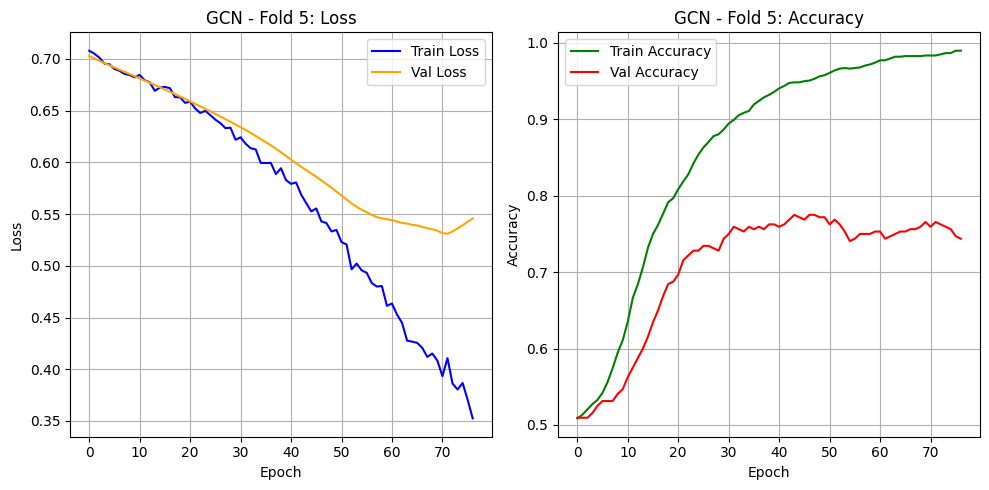


Fold 5 Validation Results:
  Accuracy:  0.7438
  AUC-ROC:   0.8255
  Precision: 0.6741
  Recall:    0.9437
  F1 Score:  0.7865

--------------------------------------------------
Average Validation Metrics over 5 folds:
Avg Accuracy    : 0.7269 ± 0.0297
Avg AUC         : 0.7697 ± 0.0368
Avg Precision   : 0.6633 ± 0.0123
Avg Recall      : 0.9187 ± 0.0788
Avg F1-score    : 0.7694 ± 0.0363


In [ ]:
# === Main execution ===
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    data = hetero_data.to(device)

    # Output directory
    output_dir = "fraud_detection_results"
    os.makedirs(output_dir, exist_ok=True)

    # Configuration for ONE model
    config = {
        'epochs': 100,
        'lr': 0.001,
        'n_folds': 5,
        'seed': 12,
        'verbose': True,
        'plot_curves': True,
        'weight_decay': 0.001,
        'factor': 0.2,
        'model_name': 'GCN',
        'model_params': {
            'hidden_channels': 8,
            'dropout': 0.3
        }
    }

    # Run one experiment
    model_dir = os.path.join(output_dir, config['model_name'])
    avg_metrics, std_metrics, _ = run_experiment(
        FraudHeteroGCN,
        config,
        data,
        device,
        model_dir
    )
    all_results[config['model_name']] = (avg_metrics, std_metrics)

if __name__ == "__main__":
    main()

**== SAGE ==**

Using device: cpu

 Running SAGE Experiment

Fold 1/5
Fold 1, Epoch 001: Train Loss: 0.7585, Train Acc: 0.4773, Val Loss: 0.7013, Val Acc: 0.4531


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1, Epoch 002: Train Loss: 0.7466, Train Acc: 0.5750, Val Loss: 0.6888, Val Acc: 0.5250
Fold 1, Epoch 003: Train Loss: 0.7144, Train Acc: 0.6516, Val Loss: 0.6805, Val Acc: 0.6000
Fold 1, Epoch 004: Train Loss: 0.7065, Train Acc: 0.6531, Val Loss: 0.6749, Val Acc: 0.6188
Fold 1, Epoch 005: Train Loss: 0.7030, Train Acc: 0.6344, Val Loss: 0.6699, Val Acc: 0.5969
Fold 1, Epoch 006: Train Loss: 0.6892, Train Acc: 0.6336, Val Loss: 0.6641, Val Acc: 0.6062
Fold 1, Epoch 007: Train Loss: 0.6838, Train Acc: 0.6406, Val Loss: 0.6578, Val Acc: 0.6125
Fold 1, Epoch 008: Train Loss: 0.6728, Train Acc: 0.6586, Val Loss: 0.6510, Val Acc: 0.6125
Fold 1, Epoch 009: Train Loss: 0.6704, Train Acc: 0.6781, Val Loss: 0.6440, Val Acc: 0.6219
Fold 1, Epoch 010: Train Loss: 0.6611, Train Acc: 0.7055, Val Loss: 0.6368, Val Acc: 0.6406
Fold 1, Epoch 011: Train Loss: 0.6642, Train Acc: 0.7328, Val Loss: 0.6289, Val Acc: 0.6719
Fold 1, Epoch 012: Train Loss: 0.6563, Train Acc: 0.7672, Val Loss: 0.6205, Val 

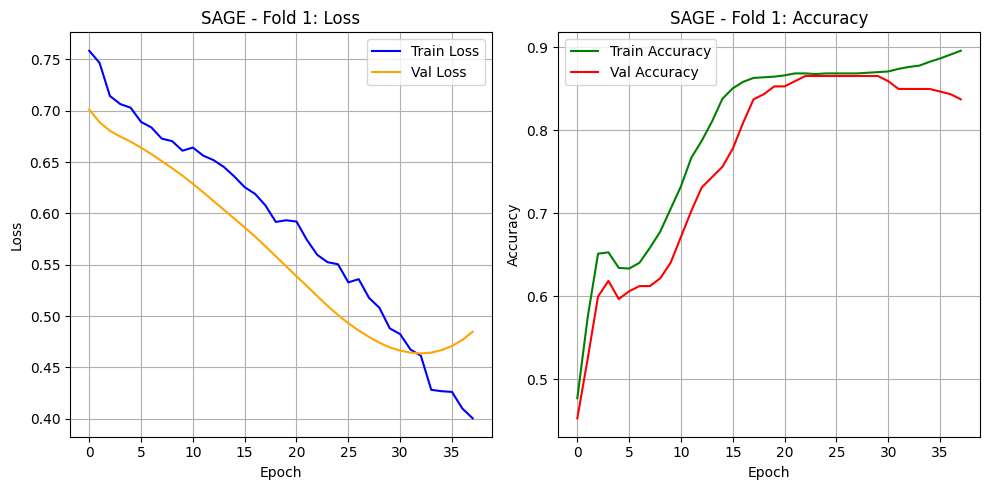


Fold 1 Validation Results:
  Accuracy:  0.8375
  AUC-ROC:   0.8184
  Precision: 0.7935
  Recall:    0.9125
  F1 Score:  0.8488

Fold 2/5
Fold 2, Epoch 001: Train Loss: 0.7659, Train Acc: 0.4883, Val Loss: 0.6949, Val Acc: 0.4875


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 2, Epoch 002: Train Loss: 0.7334, Train Acc: 0.5344, Val Loss: 0.6807, Val Acc: 0.5437
Fold 2, Epoch 003: Train Loss: 0.7170, Train Acc: 0.6203, Val Loss: 0.6717, Val Acc: 0.6125
Fold 2, Epoch 004: Train Loss: 0.7077, Train Acc: 0.6617, Val Loss: 0.6663, Val Acc: 0.6500
Fold 2, Epoch 005: Train Loss: 0.6966, Train Acc: 0.6711, Val Loss: 0.6625, Val Acc: 0.6469
Fold 2, Epoch 006: Train Loss: 0.6835, Train Acc: 0.6656, Val Loss: 0.6590, Val Acc: 0.6500
Fold 2, Epoch 007: Train Loss: 0.6757, Train Acc: 0.6633, Val Loss: 0.6555, Val Acc: 0.6406
Fold 2, Epoch 008: Train Loss: 0.6706, Train Acc: 0.6695, Val Loss: 0.6516, Val Acc: 0.6375
Fold 2, Epoch 009: Train Loss: 0.6755, Train Acc: 0.6820, Val Loss: 0.6470, Val Acc: 0.6469
Fold 2, Epoch 010: Train Loss: 0.6671, Train Acc: 0.6945, Val Loss: 0.6419, Val Acc: 0.6625
Fold 2, Epoch 011: Train Loss: 0.6561, Train Acc: 0.7063, Val Loss: 0.6365, Val Acc: 0.6656
Fold 2, Epoch 012: Train Loss: 0.6506, Train Acc: 0.7227, Val Loss: 0.6309, Val 

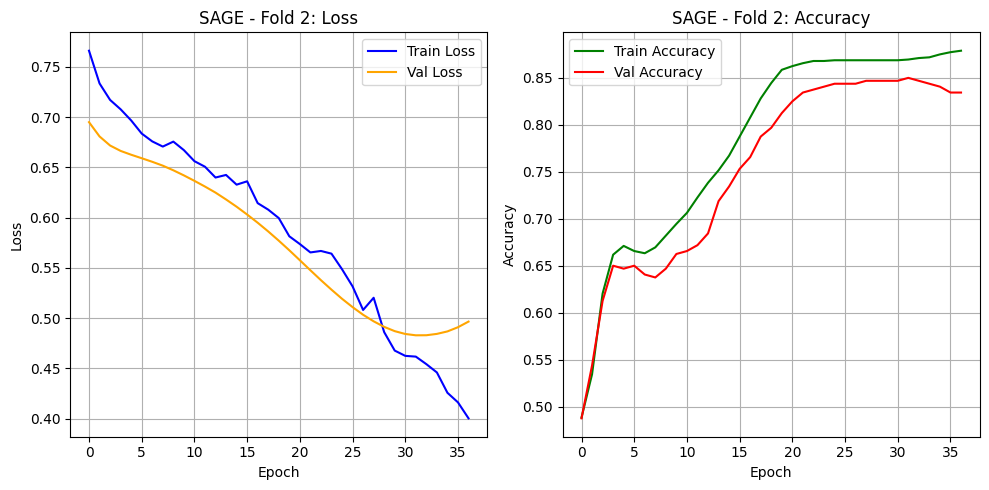


Fold 2 Validation Results:
  Accuracy:  0.8344
  AUC-ROC:   0.7776
  Precision: 0.7662
  Recall:    0.9625
  F1 Score:  0.8532

Fold 3/5
Fold 3, Epoch 001: Train Loss: 0.7224, Train Acc: 0.6227, Val Loss: 0.6735, Val Acc: 0.6250


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 3, Epoch 002: Train Loss: 0.7148, Train Acc: 0.7000, Val Loss: 0.6678, Val Acc: 0.6937
Fold 3, Epoch 003: Train Loss: 0.6965, Train Acc: 0.7109, Val Loss: 0.6630, Val Acc: 0.6719
Fold 3, Epoch 004: Train Loss: 0.6962, Train Acc: 0.7164, Val Loss: 0.6581, Val Acc: 0.6687
Fold 3, Epoch 005: Train Loss: 0.6751, Train Acc: 0.7352, Val Loss: 0.6522, Val Acc: 0.6625
Fold 3, Epoch 006: Train Loss: 0.6776, Train Acc: 0.7641, Val Loss: 0.6452, Val Acc: 0.6750
Fold 3, Epoch 007: Train Loss: 0.6650, Train Acc: 0.8078, Val Loss: 0.6372, Val Acc: 0.7219
Fold 3, Epoch 008: Train Loss: 0.6655, Train Acc: 0.8320, Val Loss: 0.6286, Val Acc: 0.7781
Fold 3, Epoch 009: Train Loss: 0.6560, Train Acc: 0.8664, Val Loss: 0.6191, Val Acc: 0.8000
Fold 3, Epoch 010: Train Loss: 0.6498, Train Acc: 0.8703, Val Loss: 0.6094, Val Acc: 0.8406
Fold 3, Epoch 011: Train Loss: 0.6385, Train Acc: 0.8758, Val Loss: 0.5997, Val Acc: 0.8406
Fold 3, Epoch 012: Train Loss: 0.6470, Train Acc: 0.8766, Val Loss: 0.5904, Val 

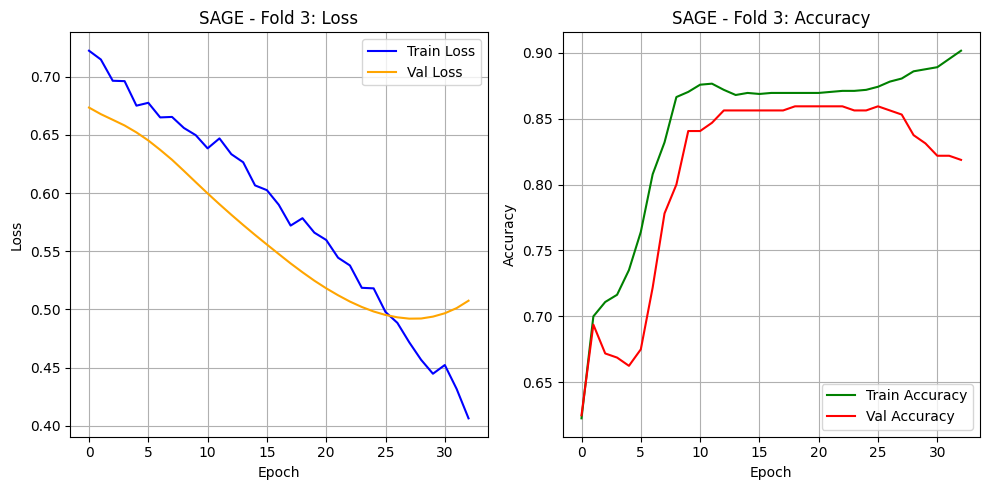


Fold 3 Validation Results:
  Accuracy:  0.8187
  AUC-ROC:   0.7960
  Precision: 0.7713
  Recall:    0.9062
  F1 Score:  0.8333

Fold 4/5
Fold 4, Epoch 001: Train Loss: 0.7336, Train Acc: 0.5211, Val Loss: 0.6881, Val Acc: 0.5094


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 4, Epoch 002: Train Loss: 0.7226, Train Acc: 0.6133, Val Loss: 0.6718, Val Acc: 0.6031
Fold 4, Epoch 003: Train Loss: 0.7120, Train Acc: 0.7055, Val Loss: 0.6591, Val Acc: 0.6594
Fold 4, Epoch 004: Train Loss: 0.6945, Train Acc: 0.7742, Val Loss: 0.6490, Val Acc: 0.7688
Fold 4, Epoch 005: Train Loss: 0.6829, Train Acc: 0.8031, Val Loss: 0.6405, Val Acc: 0.7844
Fold 4, Epoch 006: Train Loss: 0.6767, Train Acc: 0.8133, Val Loss: 0.6328, Val Acc: 0.8125
Fold 4, Epoch 007: Train Loss: 0.6717, Train Acc: 0.8195, Val Loss: 0.6266, Val Acc: 0.8219
Fold 4, Epoch 008: Train Loss: 0.6741, Train Acc: 0.8297, Val Loss: 0.6207, Val Acc: 0.8375
Fold 4, Epoch 009: Train Loss: 0.6482, Train Acc: 0.8461, Val Loss: 0.6149, Val Acc: 0.8500
Fold 4, Epoch 010: Train Loss: 0.6499, Train Acc: 0.8539, Val Loss: 0.6089, Val Acc: 0.8531
Fold 4, Epoch 011: Train Loss: 0.6436, Train Acc: 0.8602, Val Loss: 0.6026, Val Acc: 0.8656
Fold 4, Epoch 012: Train Loss: 0.6530, Train Acc: 0.8633, Val Loss: 0.5964, Val 

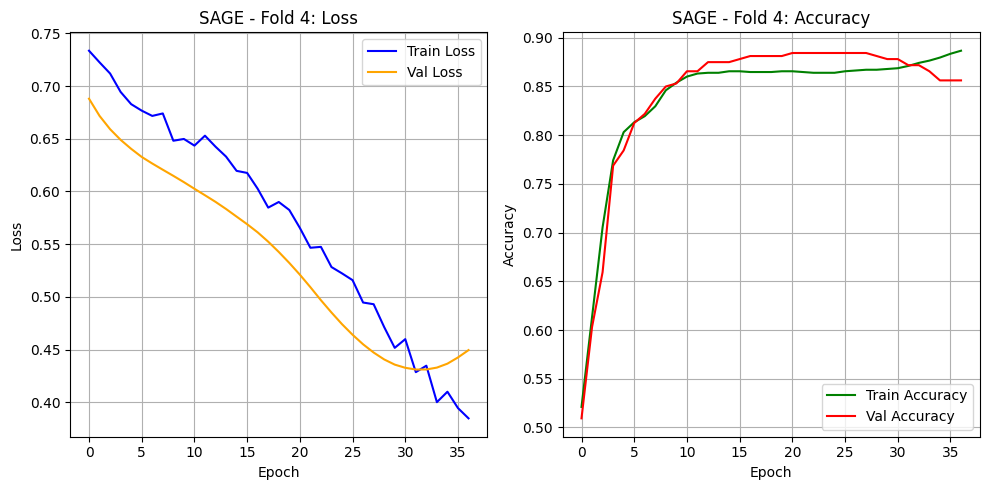


Fold 4 Validation Results:
  Accuracy:  0.8562
  AUC-ROC:   0.8391
  Precision: 0.8167
  Recall:    0.9187
  F1 Score:  0.8647

Fold 5/5
Fold 5, Epoch 001: Train Loss: 0.7404, Train Acc: 0.5414, Val Loss: 0.6969, Val Acc: 0.5188


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 5, Epoch 002: Train Loss: 0.7095, Train Acc: 0.6000, Val Loss: 0.6883, Val Acc: 0.5563
Fold 5, Epoch 003: Train Loss: 0.7105, Train Acc: 0.6687, Val Loss: 0.6816, Val Acc: 0.6188
Fold 5, Epoch 004: Train Loss: 0.7006, Train Acc: 0.7328, Val Loss: 0.6757, Val Acc: 0.6594
Fold 5, Epoch 005: Train Loss: 0.6893, Train Acc: 0.7820, Val Loss: 0.6707, Val Acc: 0.6844
Fold 5, Epoch 006: Train Loss: 0.6955, Train Acc: 0.8063, Val Loss: 0.6664, Val Acc: 0.7031
Fold 5, Epoch 007: Train Loss: 0.6736, Train Acc: 0.8227, Val Loss: 0.6620, Val Acc: 0.7281
Fold 5, Epoch 008: Train Loss: 0.6715, Train Acc: 0.8367, Val Loss: 0.6571, Val Acc: 0.7562
Fold 5, Epoch 009: Train Loss: 0.6657, Train Acc: 0.8422, Val Loss: 0.6519, Val Acc: 0.7719
Fold 5, Epoch 010: Train Loss: 0.6628, Train Acc: 0.8484, Val Loss: 0.6464, Val Acc: 0.7844
Fold 5, Epoch 011: Train Loss: 0.6610, Train Acc: 0.8508, Val Loss: 0.6405, Val Acc: 0.7875
Fold 5, Epoch 012: Train Loss: 0.6576, Train Acc: 0.8578, Val Loss: 0.6342, Val 

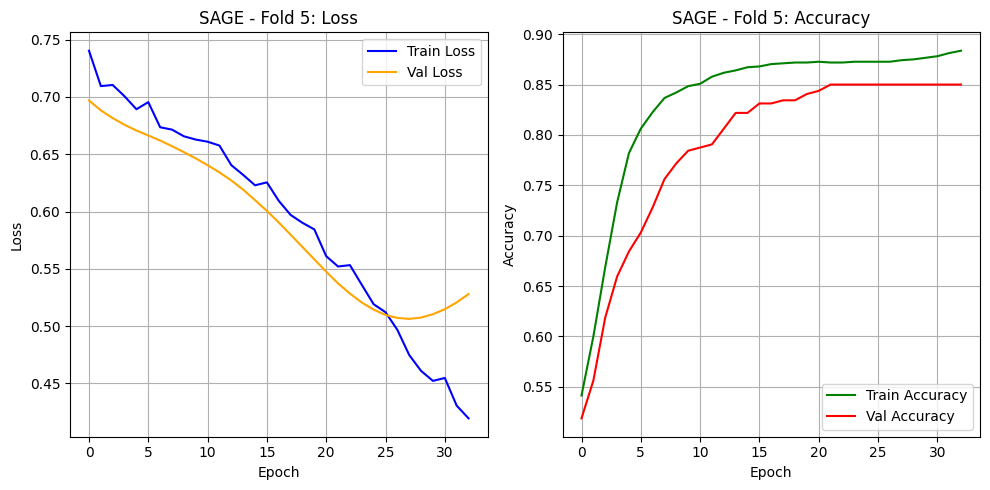


Fold 5 Validation Results:
  Accuracy:  0.8500
  AUC-ROC:   0.7823
  Precision: 0.7772
  Recall:    0.9812
  F1 Score:  0.8674

--------------------------------------------------
Average Validation Metrics over 5 folds:
Avg Accuracy    : 0.8394 ± 0.0131
Avg AUC         : 0.8027 ± 0.0231
Avg Precision   : 0.7850 ± 0.0183
Avg Recall      : 0.9363 ± 0.0299
Avg F1-score    : 0.8535 ± 0.0122


In [ ]:
# === Main execution ===
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    data = hetero_data.to(device)

    # Output directory
    output_dir = "fraud_detection_results"
    os.makedirs(output_dir, exist_ok=True)

    # Configuration for ONE model
    config = {
        'epochs': 100,
        'lr': 0.001,
        'n_folds': 5,
        'seed': 12,
        'verbose': True,
        'plot_curves': True,
        'weight_decay': 0.0008,
        'factor': 0.1,
        'model_name': 'SAGE',
        'model_params': {
            'hidden_channels': 32,
            'dropout': 0.5
        }
    }

    # Run one experiment
    model_dir = os.path.join(output_dir, config['model_name'])
    avg_metrics, std_metrics, _ = run_experiment(
        FraudHeteroGNN,
        config,
        data,
        device,
        model_dir
    )


if __name__ == "__main__":
    main()

**== GAT ==**

Using device: cpu

 Running GAT Experiment

Fold 1/5
Fold 1, Epoch 001: Train Loss: 0.7260, Train Acc: 0.6273, Val Loss: 0.6643, Val Acc: 0.6000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1, Epoch 002: Train Loss: 0.7001, Train Acc: 0.7000, Val Loss: 0.6541, Val Acc: 0.6750
Fold 1, Epoch 003: Train Loss: 0.6928, Train Acc: 0.7711, Val Loss: 0.6447, Val Acc: 0.7156
Fold 1, Epoch 004: Train Loss: 0.6808, Train Acc: 0.8359, Val Loss: 0.6352, Val Acc: 0.7688
Fold 1, Epoch 005: Train Loss: 0.6763, Train Acc: 0.8711, Val Loss: 0.6260, Val Acc: 0.8156
Fold 1, Epoch 006: Train Loss: 0.6615, Train Acc: 0.8875, Val Loss: 0.6170, Val Acc: 0.8406
Fold 1, Epoch 007: Train Loss: 0.6557, Train Acc: 0.9039, Val Loss: 0.6079, Val Acc: 0.8438
Fold 1, Epoch 008: Train Loss: 0.6489, Train Acc: 0.9094, Val Loss: 0.5991, Val Acc: 0.8594
Fold 1, Epoch 009: Train Loss: 0.6230, Train Acc: 0.9109, Val Loss: 0.5904, Val Acc: 0.8594
Fold 1, Epoch 010: Train Loss: 0.6354, Train Acc: 0.9125, Val Loss: 0.5815, Val Acc: 0.8656
Fold 1, Epoch 011: Train Loss: 0.6229, Train Acc: 0.9180, Val Loss: 0.5724, Val Acc: 0.8688
Fold 1, Epoch 012: Train Loss: 0.5983, Train Acc: 0.9273, Val Loss: 0.5631, Val 

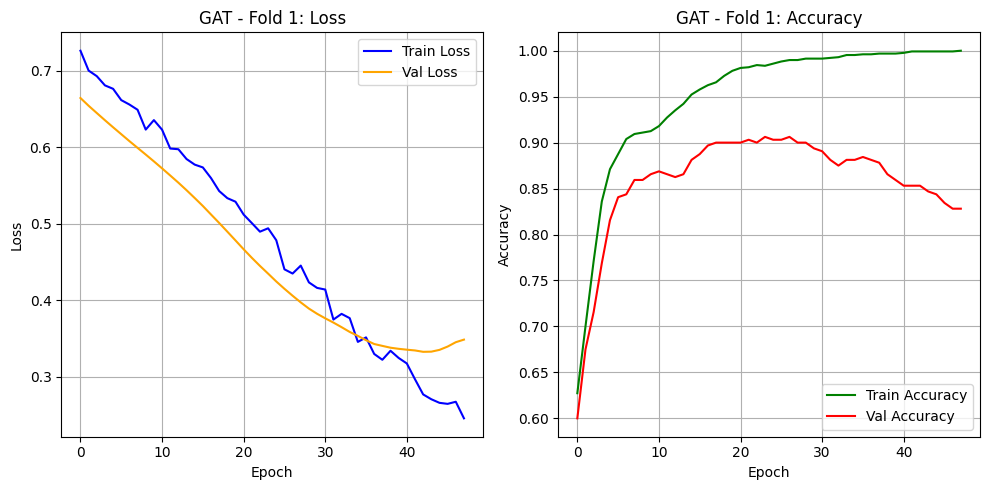


Fold 1 Validation Results:
  Accuracy:  0.8281
  AUC-ROC:   0.9841
  Precision: 0.7465
  Recall:    0.9938
  F1 Score:  0.8525

Fold 2/5
Fold 2, Epoch 001: Train Loss: 0.7667, Train Acc: 0.4203, Val Loss: 0.7276, Val Acc: 0.3625


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 2, Epoch 002: Train Loss: 0.7395, Train Acc: 0.5016, Val Loss: 0.7072, Val Acc: 0.4344
Fold 2, Epoch 003: Train Loss: 0.7380, Train Acc: 0.5945, Val Loss: 0.6868, Val Acc: 0.5437
Fold 2, Epoch 004: Train Loss: 0.7155, Train Acc: 0.6758, Val Loss: 0.6683, Val Acc: 0.6219
Fold 2, Epoch 005: Train Loss: 0.6900, Train Acc: 0.7500, Val Loss: 0.6501, Val Acc: 0.6937
Fold 2, Epoch 006: Train Loss: 0.6846, Train Acc: 0.8070, Val Loss: 0.6331, Val Acc: 0.7594
Fold 2, Epoch 007: Train Loss: 0.6758, Train Acc: 0.8391, Val Loss: 0.6168, Val Acc: 0.8063
Fold 2, Epoch 008: Train Loss: 0.6470, Train Acc: 0.8680, Val Loss: 0.6013, Val Acc: 0.8344
Fold 2, Epoch 009: Train Loss: 0.6499, Train Acc: 0.8930, Val Loss: 0.5867, Val Acc: 0.8531
Fold 2, Epoch 010: Train Loss: 0.6207, Train Acc: 0.9008, Val Loss: 0.5725, Val Acc: 0.8562
Fold 2, Epoch 011: Train Loss: 0.6204, Train Acc: 0.9102, Val Loss: 0.5587, Val Acc: 0.8750
Fold 2, Epoch 012: Train Loss: 0.6065, Train Acc: 0.9164, Val Loss: 0.5456, Val 

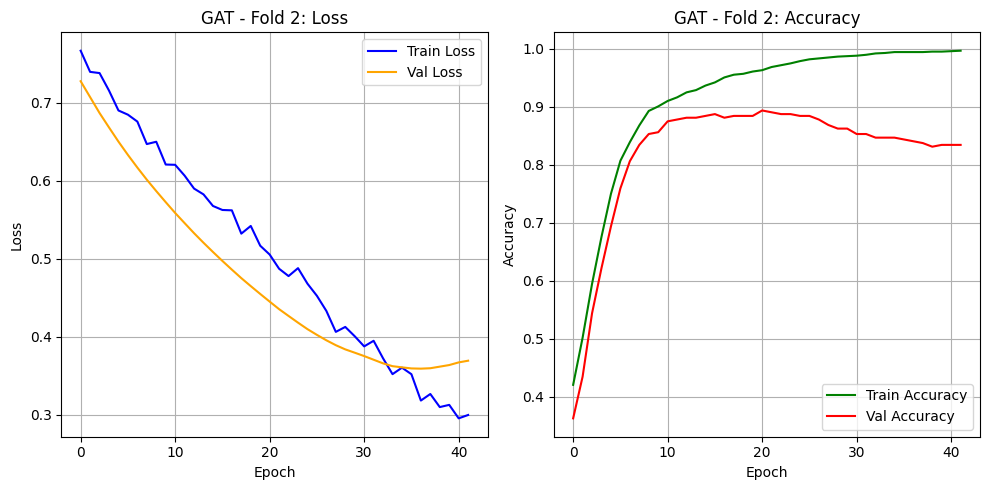


Fold 2 Validation Results:
  Accuracy:  0.8344
  AUC-ROC:   0.9777
  Precision: 0.7512
  Recall:    1.0000
  F1 Score:  0.8579

Fold 3/5
Fold 3, Epoch 001: Train Loss: 0.7445, Train Acc: 0.5367, Val Loss: 0.6780, Val Acc: 0.5563


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 3, Epoch 002: Train Loss: 0.7257, Train Acc: 0.6203, Val Loss: 0.6580, Val Acc: 0.6031
Fold 3, Epoch 003: Train Loss: 0.7122, Train Acc: 0.6883, Val Loss: 0.6393, Val Acc: 0.6687
Fold 3, Epoch 004: Train Loss: 0.6922, Train Acc: 0.7547, Val Loss: 0.6217, Val Acc: 0.7375
Fold 3, Epoch 005: Train Loss: 0.6732, Train Acc: 0.8156, Val Loss: 0.6054, Val Acc: 0.7719
Fold 3, Epoch 006: Train Loss: 0.6746, Train Acc: 0.8500, Val Loss: 0.5908, Val Acc: 0.8187
Fold 3, Epoch 007: Train Loss: 0.6490, Train Acc: 0.8750, Val Loss: 0.5771, Val Acc: 0.8500
Fold 3, Epoch 008: Train Loss: 0.6563, Train Acc: 0.8984, Val Loss: 0.5642, Val Acc: 0.8594
Fold 3, Epoch 009: Train Loss: 0.6346, Train Acc: 0.9125, Val Loss: 0.5520, Val Acc: 0.8719
Fold 3, Epoch 010: Train Loss: 0.6203, Train Acc: 0.9180, Val Loss: 0.5405, Val Acc: 0.8781
Fold 3, Epoch 011: Train Loss: 0.6154, Train Acc: 0.9289, Val Loss: 0.5294, Val Acc: 0.8750
Fold 3, Epoch 012: Train Loss: 0.5929, Train Acc: 0.9359, Val Loss: 0.5180, Val 

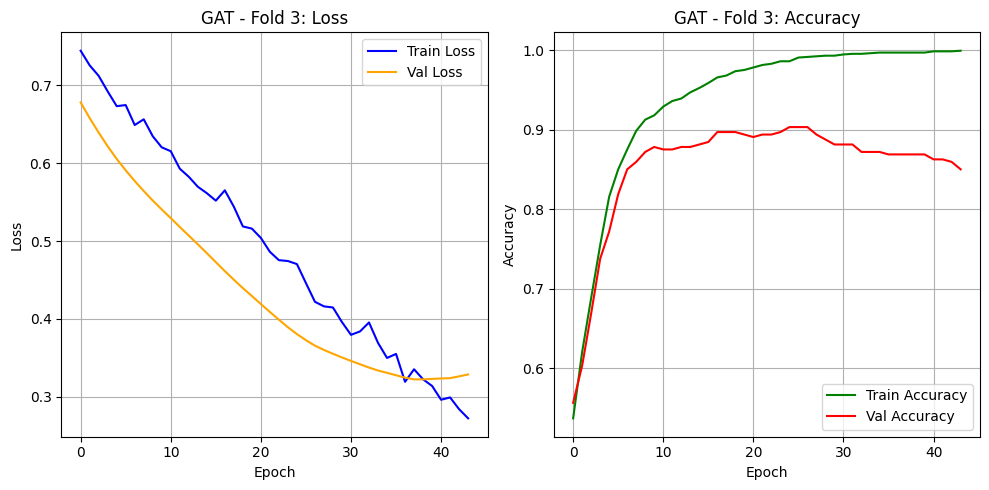


Fold 3 Validation Results:
  Accuracy:  0.8500
  AUC-ROC:   0.9911
  Precision: 0.7692
  Recall:    1.0000
  F1 Score:  0.8696

Fold 4/5
Fold 4, Epoch 001: Train Loss: 0.8121, Train Acc: 0.4867, Val Loss: 0.7310, Val Acc: 0.4875


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 4, Epoch 002: Train Loss: 0.7563, Train Acc: 0.5172, Val Loss: 0.7008, Val Acc: 0.4969
Fold 4, Epoch 003: Train Loss: 0.7397, Train Acc: 0.5719, Val Loss: 0.6738, Val Acc: 0.5594
Fold 4, Epoch 004: Train Loss: 0.7213, Train Acc: 0.6430, Val Loss: 0.6498, Val Acc: 0.6250
Fold 4, Epoch 005: Train Loss: 0.6909, Train Acc: 0.7195, Val Loss: 0.6281, Val Acc: 0.6969
Fold 4, Epoch 006: Train Loss: 0.6811, Train Acc: 0.7984, Val Loss: 0.6086, Val Acc: 0.7719
Fold 4, Epoch 007: Train Loss: 0.6709, Train Acc: 0.8562, Val Loss: 0.5908, Val Acc: 0.8375
Fold 4, Epoch 008: Train Loss: 0.6383, Train Acc: 0.8953, Val Loss: 0.5745, Val Acc: 0.8812
Fold 4, Epoch 009: Train Loss: 0.6321, Train Acc: 0.9281, Val Loss: 0.5590, Val Acc: 0.9000
Fold 4, Epoch 010: Train Loss: 0.6243, Train Acc: 0.9414, Val Loss: 0.5442, Val Acc: 0.9187
Fold 4, Epoch 011: Train Loss: 0.6094, Train Acc: 0.9578, Val Loss: 0.5298, Val Acc: 0.9313
Fold 4, Epoch 012: Train Loss: 0.6087, Train Acc: 0.9617, Val Loss: 0.5156, Val 

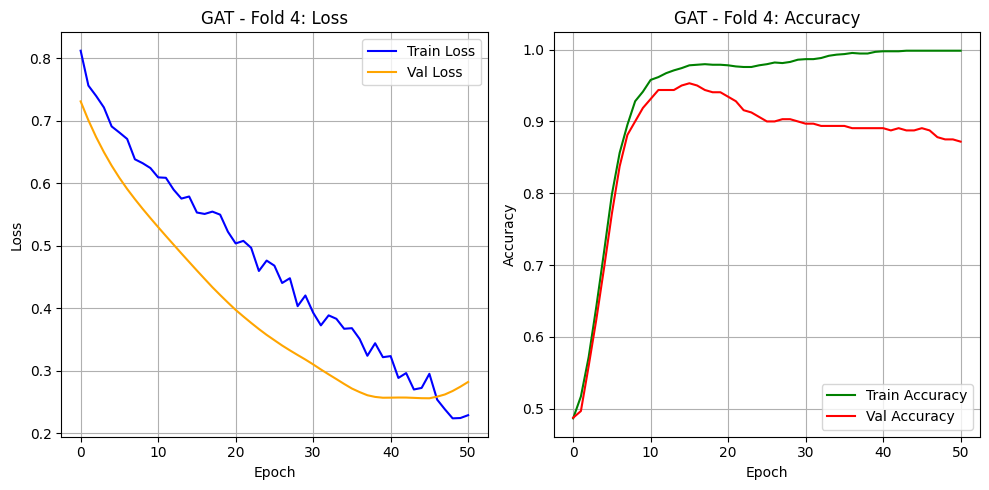


Fold 4 Validation Results:
  Accuracy:  0.8719
  AUC-ROC:   0.9937
  Precision: 0.7960
  Recall:    1.0000
  F1 Score:  0.8864

Fold 5/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 5, Epoch 001: Train Loss: 0.7570, Train Acc: 0.4961, Val Loss: 0.6961, Val Acc: 0.5031
Fold 5, Epoch 002: Train Loss: 0.7499, Train Acc: 0.5141, Val Loss: 0.6743, Val Acc: 0.5094
Fold 5, Epoch 003: Train Loss: 0.7093, Train Acc: 0.5547, Val Loss: 0.6548, Val Acc: 0.5437
Fold 5, Epoch 004: Train Loss: 0.6987, Train Acc: 0.6328, Val Loss: 0.6369, Val Acc: 0.6062
Fold 5, Epoch 005: Train Loss: 0.6628, Train Acc: 0.7188, Val Loss: 0.6198, Val Acc: 0.6875
Fold 5, Epoch 006: Train Loss: 0.6593, Train Acc: 0.8047, Val Loss: 0.6034, Val Acc: 0.7406
Fold 5, Epoch 007: Train Loss: 0.6401, Train Acc: 0.8656, Val Loss: 0.5881, Val Acc: 0.8156
Fold 5, Epoch 008: Train Loss: 0.6246, Train Acc: 0.9070, Val Loss: 0.5731, Val Acc: 0.8531
Fold 5, Epoch 009: Train Loss: 0.6255, Train Acc: 0.9336, Val Loss: 0.5583, Val Acc: 0.8906
Fold 5, Epoch 010: Train Loss: 0.6025, Train Acc: 0.9594, Val Loss: 0.5438, Val Acc: 0.9219
Fold 5, Epoch 011: Train Loss: 0.5849, Train Acc: 0.9711, Val Loss: 0.5286, Val 

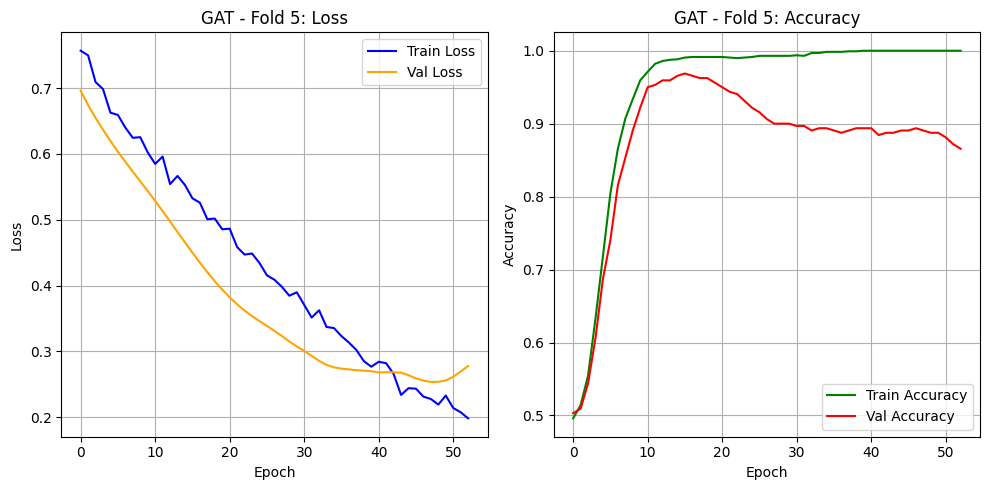


Fold 5 Validation Results:
  Accuracy:  0.8656
  AUC-ROC:   0.9947
  Precision: 0.7882
  Recall:    1.0000
  F1 Score:  0.8815

--------------------------------------------------
Average Validation Metrics over 5 folds:
Avg Accuracy    : 0.8500 ± 0.0170
Avg AUC         : 0.9883 ± 0.0065
Avg Precision   : 0.7702 ± 0.0196
Avg Recall      : 0.9988 ± 0.0025
Avg F1-score    : 0.8696 ± 0.0131


In [ ]:
# === Main execution ===
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load data
    data = hetero_data.to(device)

    # Output directory
    output_dir = "fraud_detection_results"
    os.makedirs(output_dir, exist_ok=True)

    # Configuration for ONE model
    config = {
        'epochs': 100,
        'lr': 0.001,
        'n_folds': 5,
        'seed': 12,
        'verbose': True,
        'plot_curves': True,
        'weight_decay': 0.001,
        'factor': 0.1,
        'model_name': 'GAT',
        'model_params': {
            'hidden_channels': 32,
            'dropout': 0.5,
            'heads': 2
        }
    }

    # Run one experiment
    model_dir = os.path.join(output_dir, config['model_name'])
    avg_metrics, std_metrics, _ = run_experiment(
        FraudHeteroGAT,
        config,
        data,
        device,
        model_dir
    )

    all_results[config['model_name']] = (avg_metrics, std_metrics)

if __name__ == "__main__":
    main()

## 8. Evaluation & Testing

In [ ]:
def print_comparison(results):
    """Prints comparison table with ± std dev"""
    print("\n=== Model Comparison ===")
    print(f"{'Model':<12} {'Accuracy':<18} {'AUC':<13} {'Precision':<17} {'Recall':<15}  {'F1-Score':<20}")
    for name, (metrics, stds) in results.items():
        print(f"{name:<8} "
              f"{metrics['accuracy']:.4f} ± {stds['accuracy']:.4f}  "
              f"{metrics['auc']:.4f} ± {stds['auc']:.4f}  "
              f"{metrics['precision']:.4f} ± {stds['precision']:.4f}  "
              f"{metrics['recall']:.4f} ± {stds['recall']:.4f}  "
              f"{metrics['f1']:.4f} ± {stds['f1']:.4f}")

# Compare
print_comparison(all_results)


=== Model Comparison ===
Model        Accuracy           AUC           Precision         Recall           F1-Score            
GCN      0.7269 ± 0.0297  0.7697 ± 0.0368  0.6633 ± 0.0123  0.9187 ± 0.0788  0.7694 ± 0.0363
SAGE     0.8394 ± 0.0131  0.8027 ± 0.0231  0.7850 ± 0.0183  0.9363 ± 0.0299  0.8535 ± 0.0122
GAT      0.8500 ± 0.0170  0.9883 ± 0.0065  0.7702 ± 0.0196  0.9988 ± 0.0025  0.8696 ± 0.0131


**== Testing ==**

In [ ]:
def test_model(model_class, config, data, device):
    """Load all fold models and test on ensemble"""
    model_dir = os.path.join("fraud_detection_results", config['model_name'])

    # Load all fold models
    models = []
    for fold_idx in range(config['n_folds']):
        model = model_class(data.metadata(), **config['model_params']).to(device)
        model.load_state_dict(torch.load(os.path.join(model_dir, f'best_fold{fold_idx}.pt')))
        models.append(model)

    # Prepare test data
    test_edge_index = torch.tensor(splits['test']['edge_index'], device=device)
    test_edge_label = torch.tensor(splits['test']['edge_label'], device=device)

    # Ensemble predictions
    all_probs = []
    for model in models:
        model.eval()
        with torch.no_grad():
            z_dict = model(data.x_dict, data.edge_index_dict)
            logits = model.decode(z_dict, test_edge_index).squeeze()
            all_probs.append(torch.sigmoid(logits).cpu().numpy())

    avg_probs = np.mean(all_probs, axis=0)
    final_preds = (avg_probs > 0.5).astype(int)
    true_labels = test_edge_label.cpu().numpy()

    # Calculate metrics
    metrics = {
        'models': models,
        'accuracy': accuracy_score(test_edge_label.cpu(), final_preds),
        'auc': roc_auc_score(test_edge_label.cpu(), avg_probs),
        'precision': precision_score(test_edge_label.cpu(), final_preds),
        'recall': recall_score(test_edge_label.cpu(), final_preds),
        'f1': f1_score(test_edge_label.cpu(), final_preds),
        'probs': avg_probs,  # Keep probabilities for analysis
        'preds': final_preds,  # Keep predictions
        'true_labels': true_labels
    }

    return metrics

In [ ]:
# 1. Define GAT config (correct format)
gat_config = {
    'epochs': 100,
    'lr': 0.001,
    'n_folds': 5,
    'seed': 12,
    'verbose': True,
    'plot_curves': True,
    'weight_decay': 0.001,
    'factor': 0.1,
    'model_name': 'GAT',
    'model_params': {
        'hidden_channels': 32,
        'dropout': 0.5,
        'heads': 2
    }
}

# 2. Run test
gat_results = test_model(FraudHeteroGAT, gat_config, data, device)

# 3. Print results (fixed dictionary access)
print(f"\n=== GAT Test Results ===")
print(f"Accuracy : {gat_results['accuracy']:.4f}")
print(f"AUC      : {gat_results['auc']:.4f}")
print(f"Precision: {gat_results['precision']:.4f}")
print(f"Recall   : {gat_results['recall']:.4f}")
print(f"F1       : {gat_results['f1']:.4f}")


=== GAT Test Results ===
Accuracy : 0.9125
AUC      : 0.9945
Precision: 0.8511
Recall   : 1.0000
F1       : 0.9195


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


def plot_confusion_matrix(true_labels, preds, model_name=""):
    cm = confusion_matrix(true_labels, preds)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    sns.heatmap(cm_percent, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=['Legit', 'Fraud'],
                yticklabels=['Legit', 'Fraud'],
                vmin=0, vmax=1)

    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


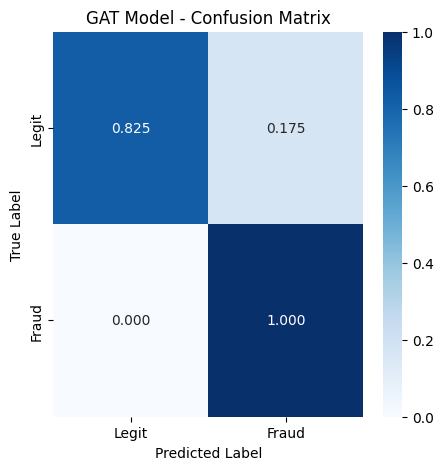

In [ ]:
# 1. Plot Confustion Matrix
plot_confusion_matrix(gat_results['true_labels'],
                     gat_results['preds'],
                     "GAT Model")

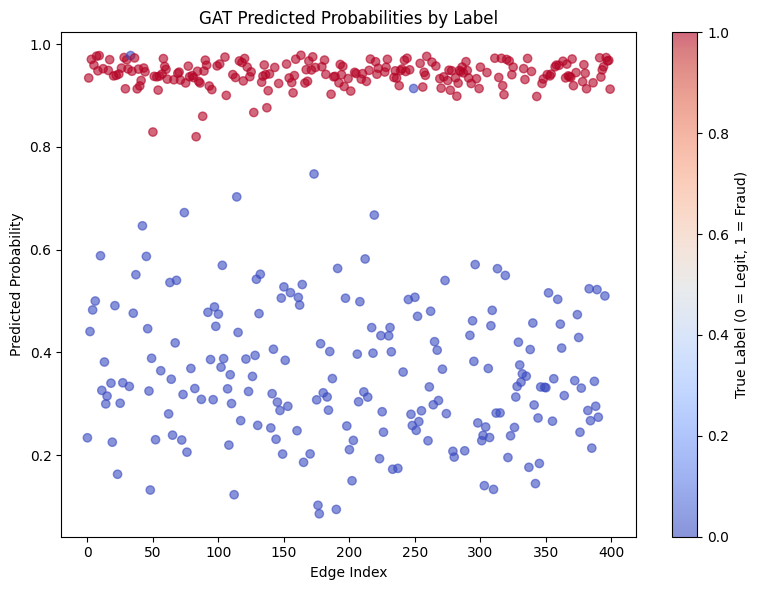

In [ ]:
# Predicted Probabilities plot

probs = gat_results['probs']       # shape: (N,)
labels = gat_results['true_labels']     # shape: (N,)

plt.figure(figsize=(8, 6))
plt.scatter(range(len(probs)), probs, c=labels, cmap='coolwarm', alpha=0.6)
plt.colorbar(label='True Label (0 = Legit, 1 = Fraud)')
plt.title("GAT Predicted Probabilities by Label")
plt.xlabel("Edge Index")
plt.ylabel("Predicted Probability")
plt.tight_layout()
plt.show()


In [ ]:
def plot_highest_attention_weights(model, data, edge_index, edge_label, edge_preds, num_edges=100):
    """Visualize highest GAT attention weights, aligned with input edges"""
    model.eval()
    with torch.no_grad():
        edge_type = ('account', 'transacts', 'account')

        # Forward pass to get embeddings
        x_dict = model.conv1(data.x_dict, data.edge_index_dict)
        x_dict = {k: model.norm1(x) for k, x in x_dict.items()}
        x_dict = {k: F.elu(x) for k, x in x_dict.items()}

        conv = model.conv2.convs[edge_type]

        # Get attention weights for all processed edges
        _, (attn_edge_index, weights) = conv(
            (x_dict['account'], x_dict['account']),
            edge_index,  # Same edge_index as train
            return_attention_weights=True
        )

        weights = weights.mean(dim=1).cpu().numpy() if weights.dim() > 1 else weights.cpu().numpy()
        attn_edge_index_np = attn_edge_index.cpu().numpy()
        edge_index_np = edge_index.cpu().numpy()

        # Build mapping from original input edges to labels and preds
        original_edges = list(zip(edge_index_np[0], edge_index_np[1]))
        edge_to_label = {e: l.item() for e, l in zip(original_edges, edge_label)}
        edge_to_pred = {e: p.item() for e, p in zip(original_edges, edge_preds)}

        # Filter attention outputs to only those that exist in original input
        filtered_data = []
        for i in range(attn_edge_index_np.shape[1]):
            e = (attn_edge_index_np[0][i], attn_edge_index_np[1][i])
            if e in edge_to_label:
                filtered_data.append({
                    'Source': e[0],
                    'Target': e[1],
                    'Attention': weights[i],
                    'Label': edge_to_label[e],
                    'Pred': edge_to_pred[e]
                })

        # Create DataFrame
        attention_df = pd.DataFrame(filtered_data)

        # Classify outcome
        conditions = [
            (attention_df['Label'] == 1) & (attention_df['Pred'] > 0.5),
            (attention_df['Label'] == 0) & (attention_df['Pred'] > 0.5),
            (attention_df['Label'] == 0) & (attention_df['Pred'] <= 0.5),
            (attention_df['Label'] == 1) & (attention_df['Pred'] <= 0.5)
        ]
        attention_df['Outcome'] = np.select(
    conditions,
    ['TP', 'FP', 'TN', 'FN'],
    default='Other'
)


        # Plot top-N
        top_attention_df = attention_df.nlargest(num_edges, 'Attention')
        palette = {'TP': 'red', 'FP': 'orange', 'TN': 'skyblue', 'FN': 'teal'}

        plt.figure(figsize=(14, 6))
        sns.barplot(
            data=top_attention_df,
            x='Source',
            y='Attention',
            hue='Outcome',
            palette=palette,
            order=top_attention_df.sort_values('Attention', ascending=False)['Source']
        )
        plt.title(f"Top {num_edges} Highest Attention Weights")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        return top_attention_df


In [ ]:
# 1. Select training edges
train_edges = torch.tensor(splits['train_val']['edge_index'], device=device)
train_labels = torch.tensor(splits['train_val']['edge_label'], dtype=torch.float32, device=device)

test_edges = torch.tensor(splits['test']['edge_index'], device=device)
test_labels = torch.tensor(splits['test']['edge_label'], dtype=torch.float32, device=device)

# 2. Get node embeddings
model.eval()
with torch.no_grad():
    z_dict = model(data.x_dict, data.edge_index_dict)
    edge_preds = model.decode(z_dict, train_edges).view(-1).sigmoid()  # Ensure shape & apply sigmoid


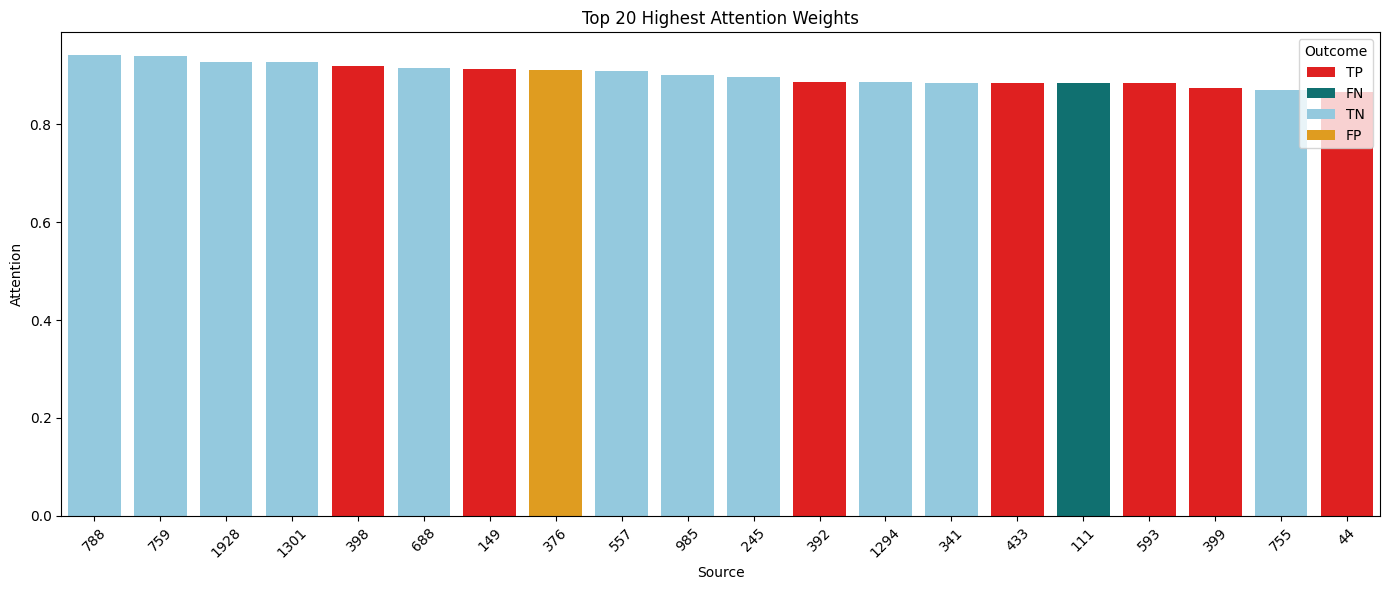

,Source,Target,Attention,Label,Pred,Outcome
341,788,1958,0.941054,0.0,3.605552e-05,TN
823,759,970,0.939071,0.0,6.774223e-10,TN
811,1928,1568,0.927292,0.0,1.678269e-08,TN
607,1301,176,0.926805,0.0,1.301200e-07,TN
1525,398,1386,0.919081,1.0,9.966822e-01,TP
289,688,960,0.915160,0.0,6.810352e-04,TN
679,149,1139,0.912185,1.0,9.999868e-01,TP
196,376,21,0.912019,0.0,5.187154e-01,FP
293,557,1463,0.908781,0.0,2.140244e-01,TN
251,985,0,0.900334,0.0,2.079038e-06,TN


In [ ]:
# Plot Attention Weights -- High Attention Weights help identify both Fraud and Non-Fraud activities
plot_highest_attention_weights(
    gat_results['models'][0], data, edge_index=train_edges, edge_label=train_labels, edge_preds=edge_preds, num_edges=20)

### GAT's Attention Weights Explained
In Graph Attention Network (GAT), attention is a lens. it highlights which parts of the graph the model looks at more when forming its prediction.

**High Attention Weights**: The model is giving more importance to these edges when making a decision. These edges could involve transactions that are more likely to have an impact on the model's output (which could be the likelihood of fraud, but not necessarily).

**Low Attention Weights**: The model considers these edges to be less influential in the decision-making process. This might mean the model sees these edges as less important when identifying fraud.

In [ ]:
def visualize_graph_with_attention(hetero_data, model, edge_type=('account', 'transacts', 'account'), num_nodes=20):
    import torch
    import matplotlib.pyplot as plt
    import networkx as nx
    from torch_geometric.data import Data
    from torch_geometric.utils import to_networkx
    import numpy as np
    import matplotlib.patches as mpatches
    import torch.nn.functional as F

    # Get model attention weights
    model.eval()
    with torch.no_grad():
        # We'll need to follow the same steps as in the model's forward method
        # Let's manually compute the first layer output and then get the attention weights

        # First conv layer
        x_dict_1 = {}
        for edge_types, conv in model.conv1.convs.items():
            src_type, _, dst_type = edge_types
            x_dict_1[dst_type] = conv(
                (hetero_data.x_dict[src_type], hetero_data.x_dict[dst_type]),
                hetero_data.edge_index_dict[edge_types]
            )

        # Apply normalization, activation, and dropout
        x_dict_normalized = {}
        for k, x in x_dict_1.items():
            # Apply operations manually rather than accessing norm1
            x = F.layer_norm(x, [x.size(-1)])  # Use functional layer_norm
            x = F.elu(x)
            x = F.dropout(x, p=model.dropout, training=False)
            x_dict_normalized[k] = x

        # Get attention weights from second layer
        conv = model.conv2.convs[edge_type]

        # Get the edge index for the specified edge type
        edge_index = hetero_data[edge_type].edge_index

        # Get attention weights
        try:
            # Try the standard way first
            _, (full_edge_index, attention_weights) = conv(
                (x_dict_normalized['account'], x_dict_normalized['account']),
                edge_index,
                return_attention_weights=True
            )
            # If multiple attention heads, average them
            if len(attention_weights.shape) > 1 and attention_weights.shape[1] > 1:
                attention_weights = attention_weights.mean(dim=1)  # Average across heads
        except ValueError as e:
            print(f"Error getting attention weights: {e}")
            # Alternative way if the above fails
            out, attention_data = conv(
                (x_dict_normalized['account'], x_dict_normalized['account']),
                edge_index,
                return_attention_weights=True
            )
            # Handle different return formats
            if isinstance(attention_data, tuple):
                full_edge_index, attention_weights = attention_data
            else:
                full_edge_index = edge_index
                attention_weights = attention_data

    # Prepare graph data
    all_edge_index = hetero_data[edge_type].edge_index
    all_edge_label = hetero_data[edge_type].edge_label

    # Make sure edge_label is a 1D tensor by squeezing if needed
    if all_edge_label.dim() > 1:
        all_edge_label = all_edge_label.squeeze()

    # Check shapes and dimensions for debugging
    print(f"Edge index shape: {all_edge_index.shape}")
    print(f"Edge label shape: {all_edge_label.shape}")

    # Handle shape mismatch between edge_index and edge_label
    # If they don't match, we need to fix our approach
    if all_edge_label.shape[0] != all_edge_index.shape[1]:
        print(f"Shape mismatch detected: edge_label ({all_edge_label.shape[0]}) does not match edge_index columns ({all_edge_index.shape[1]})")

        # Option 1: Use the appropriate number of edge labels
        if all_edge_label.shape[0] > all_edge_index.shape[1]:
            # Truncate edge_label to match edge_index
            all_edge_label = all_edge_label[:all_edge_index.shape[1]]
            print(f"Truncated edge_label to {all_edge_label.shape[0]} elements")
        else:
            # If there are fewer labels than edges, we need to pad
            pad_size = all_edge_index.shape[1] - all_edge_label.shape[0]
            padding = torch.zeros(pad_size, device=all_edge_label.device, dtype=all_edge_label.dtype)
            all_edge_label = torch.cat([all_edge_label, padding])
            print(f"Padded edge_label to {all_edge_label.shape[0]} elements")

    total_nodes = hetero_data['account'].x.size(0)
    selected_nodes = torch.randperm(total_nodes)[:num_nodes]

    # Create subgraph
    mask = (torch.isin(all_edge_index[0], selected_nodes) |
            torch.isin(all_edge_index[1], selected_nodes))

    # Print mask shape for debugging
    print(f"Mask shape: {mask.shape}")

    # Ensure mask shape matches edge_index's second dimension
    if mask.shape[0] != all_edge_index.shape[1]:
        raise ValueError(f"Mask shape {mask.shape} doesn't match edge_index second dimension {all_edge_index.shape[1]}")

    # Now apply the mask
    sub_edge_index = all_edge_index[:, mask]
    sub_edge_label = all_edge_label[mask]
    sub_nodes = torch.unique(sub_edge_index.flatten())

    # Create mapping between original and subgraph nodes
    old_to_new = {old.item(): i for i, old in enumerate(sub_nodes)}
    remapped_edge_index = torch.tensor([[old_to_new[src.item()], old_to_new[dst.item()]]
                                    for src, dst in sub_edge_index.t()], dtype=torch.long).t()

    # Get attention weights for the subgraph
    sub_edge_attention = []
    full_edge_index_np = full_edge_index.cpu().numpy()
    for i in range(sub_edge_index.size(1)):
        src, dst = sub_edge_index[:, i].cpu().numpy()
        idx = np.where((full_edge_index_np[0] == src) & (full_edge_index_np[1] == dst))[0]
        if len(idx) > 0:
            sub_edge_attention.append(attention_weights[idx[0]].item())
        else:
            sub_edge_attention.append(0.0)  # Default value if edge not found in attention

    sub_data = Data(edge_index=remapped_edge_index, num_nodes=len(sub_nodes))
    G = to_networkx(sub_data, to_undirected=False)

    # Node classification
    original_nodes = list(sub_nodes.numpy())
    original_senders = set(all_edge_index[0][mask].numpy())
    original_receivers = set(all_edge_index[1][mask].numpy())

    only_senders = []
    only_receivers = []
    both = []

    for node in original_nodes:
        is_sender = node in original_senders
        is_receiver = node in original_receivers
        if is_sender and not is_receiver:
            only_senders.append(old_to_new[node])
        elif is_receiver and not is_sender:
            only_receivers.append(old_to_new[node])
        else:
            both.append(old_to_new[node])

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    pos = nx.spring_layout(G, seed=12, k=0.2)

    # Plot 1: Actual fraud labels
    edge_colors = ['red' if is_fraud else 'grey' for is_fraud in sub_edge_label.tolist()]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, arrows=True, arrowsize=15, ax=ax1)
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=only_senders, node_color='skyblue', node_shape='o', ax=ax1)
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=only_receivers, node_color='skyblue', node_shape='s', ax=ax1)
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=both, node_color='skyblue', node_shape='*', ax=ax1)

    # Highlight fraud nodes
    fraud_edges = sub_edge_label > 0
    fraud_nodes = torch.cat([sub_edge_index[0][fraud_edges], sub_edge_index[1][fraud_edges]]).unique()
    fraud_nodes_remapped = [old_to_new[n.item()] for n in fraud_nodes]
    for node in fraud_nodes_remapped:
        x, y = pos[node]
        circle = mpatches.Circle((x, y), radius=0.045, fill=False, edgecolor='red', linestyle='dashed', linewidth=1.2)
        ax1.add_patch(circle)

    ax1.set_title("Actual Fraud Labels (Red edges = fraud)")

    # Plot 2: Attention weights
    if sub_edge_attention:  # Check if we have any attention weights
        edge_alpha = np.interp(sub_edge_attention,
                               [min(sub_edge_attention), max(sub_edge_attention) or 1.0],
                               [0.1, 1])
        edge_width = np.interp(sub_edge_attention,
                               [min(sub_edge_attention), max(sub_edge_attention) or 1.0],
                               [0.5, 3])

        nx.draw_networkx_edges(G, pos, edge_color='blue', arrows=True, arrowsize=15,
                              alpha=edge_alpha, width=edge_width, ax=ax2)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='blue', arrows=True, arrowsize=15, ax=ax2)

    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=only_senders, node_color='skyblue', node_shape='o', ax=ax2)
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=only_receivers, node_color='skyblue', node_shape='s', ax=ax2)
    nx.draw_networkx_nodes(G, pos, node_size=150, nodelist=both, node_color='skyblue', node_shape='*', ax=ax2)

    # Add colorbar for attention weights
    if sub_edge_attention and max(sub_edge_attention) > min(sub_edge_attention):
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,
                                  norm=plt.Normalize(vmin=min(sub_edge_attention),
                                                   vmax=max(sub_edge_attention)))
        sm.set_array([])
        plt.colorbar(sm, ax=ax2, label='Attention Weight')

    ax2.set_title("Model Attention Weights (Darker/thicker = higher attention)")

    plt.suptitle(f"Fraud Detection: Actual vs Model Attention (Subgraph of {num_nodes} Nodes)")
    plt.tight_layout()
    plt.show()

    return fig  # Return the figure for potential further use or saving

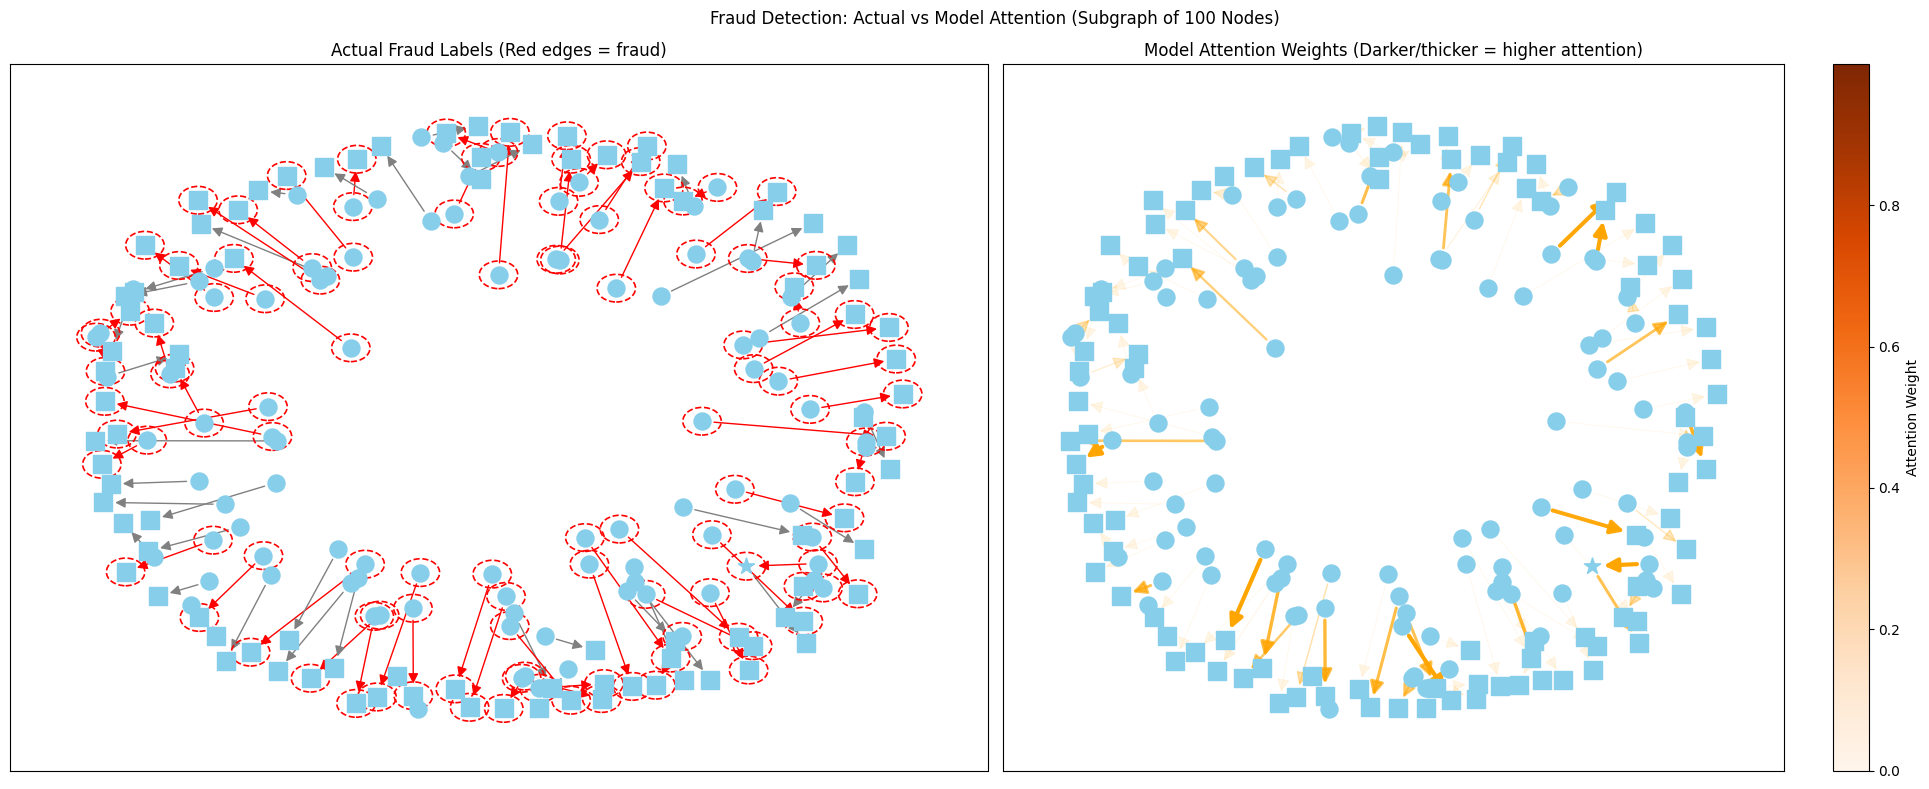

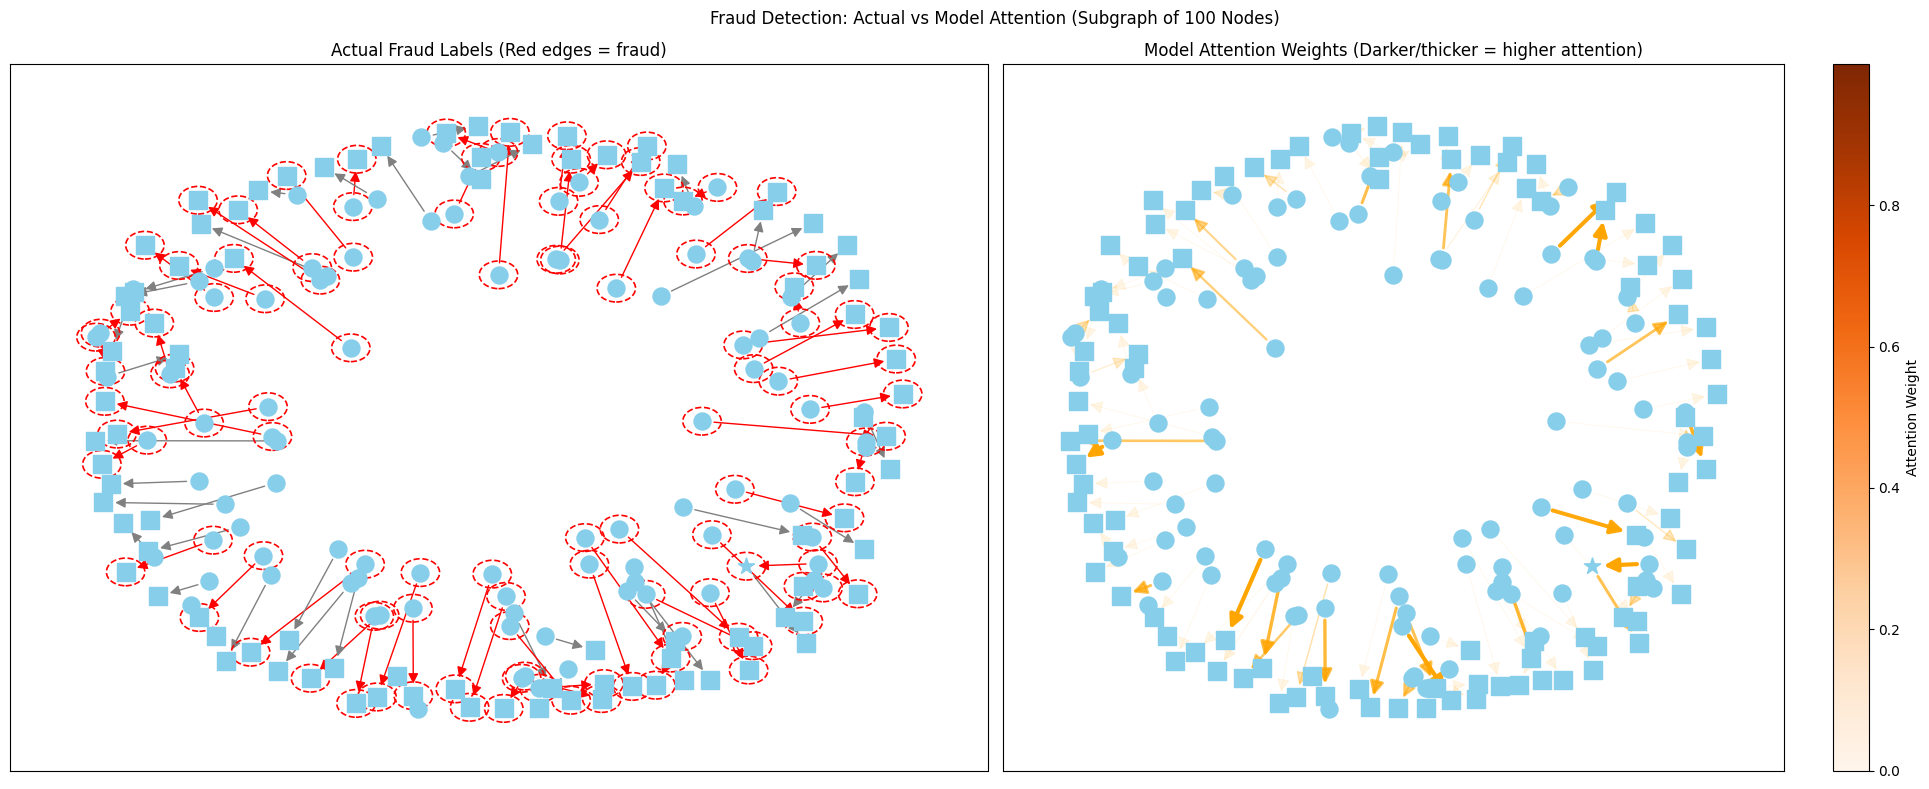

In [ ]:
visualize_graph_with_attention(hetero_data, model, edge_type=('account', 'transacts', 'account'), num_nodes=100)

# Note: Only some of the edges are used for training GAT, thus some of the edges have no attention weights.

In [ ]:
plt.close('all')  # Close all existing figures

In [ ]:
torch.cuda.empty_cache()